# AML3104 - Neural Networks and Deep Learning
# Final Project
# Group Zero Budget

Team members:
- Aanal Patel - ID: 910376
- Danilo Diaz - ID: 889539
- Ernie Sumoso - ID: 881591
- Jay Saravanan - ID: 910392
- Yogita Sharma - ID: 913011

## Table of Contents <a class="anchor" id="toc"></a>
* [Part I. Data Gathering and Exploration](#part-1)
* [Part IIa. Data Pre-processing (OBJ to NPY pipeline)](#part-2a)
* [Part IIb. Data Pre-processing (Render Images pipeline)](#part-2b)
* [Part IIc. Data Pre-processing (PNG to NPY pipeline)](#part-2c)
* [Part III. Splitting the dataset & Final Pre-processing](#part-3)
* [Part IV. Developing the CNN architecture, Training and testing (Base model)](#part-4)
* [Part V. Validating the Model and Metrics: IoU, Accuracy, Loss, Visual Comparisons (Base model)](#part-5)

### Part I. Data Gathering and Exploration <a class="anchor" id="intro"></a>

Let's collect and explore the data.

In [1]:
# importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import trimesh
import glob
import os

We downloaded the ShapeNet Core dataset (source below) into our local machine.
- https://huggingface.co/datasets/ShapeNet/ShapeNetCor

In [2]:
def get_category_names(data_path):

    # Initialize an empty array and loop through the folders within data path
    category_names = []
    for folder in os.scandir(data_path):

        # if the folder name starts with a number then it's a category name
        folder_basename = os.path.basename(folder.path)
        if folder.is_dir() and folder_basename[0].isdigit():
            category_names.append(folder_basename)
    return category_names

# Get all the available categories (types of 3D objects)
categories = get_category_names(r"D:\_Projects\ShapeNetCore")
print(f"We have {len(categories)} categories.")
print(categories)

We have 54 categories.
['02691156', '02747177', '02773838', '02801938', '02808440', '02818832', '02828884', '02843684', '02871439', '02876657', '02880940', '02924116', '02933112', '02942699', '02946921', '02954340', '02992529', '03001627', '03046257', '03085013', '03207941', '03211117', '03261776', '03325088', '03337140', '03467517', '03513137', '03593526', '03624134', '03636649', '03642806', '03691459', '03710193', '03759954', '03761084', '03790512', '03797390', '03928116', '03938244', '03948459', '03991062', '04004475', '04074963', '04090263', '04099429', '04225987', '04256520', '04330267', '04379243', '04401088', '04460130', '04468005', '04530566', '04554684']


Then, we map categories to their corresponding labels, using the following source.
- https://gist.github.com/tejaskhot/15ae62827d6e43b91a4b0c5c850c168e

In [3]:
# Set a dictionary to map category identifiers into actual labels
category_labels = {
    "04379243": "table", "03593526": "jar", "04225987": "skateboard", "02958343": "car",
    "02876657": "bottle", "04460130": "tower", "03001627": "chair", "02871439": "bookshelf",
    "02942699": "camera", "02691156": "airplane", "03642806": "laptop", "02801938": "basket",
    "04256520": "sofa", "03624134": "knife", "02946921": "can", "04090263": "rifle",
    "04468005": "train", "03938244": "pillow", "03636649": "lamp", "02747177": "trash bin",
    "03710193": "mailbox", "04530566": "watercraft", "03790512": "motorbike", "03207941": "dishwasher",
    "02828884": "bench", "03948459": "pistol", "04099429": "rocket", "03691459": "loudspeaker",
    "03337140": "file cabinet", "02773838": "bag", "02933112": "cabinet", "02818832": "bed",
    "02843684": "birdhouse", "03211117": "display", "03928116": "piano", "03261776": "earphone",
    "04401088": "telephone", "04330267": "stove", "03759954": "microphone", "02924116": "bus",
    "03797390": "mug", "04074963": "remote", "02808440": "bathtub", "02880940": "bowl",
    "03085013": "keyboard", "03467517": "guitar", "04554684": "washer", "02834778": "bicycle",
    "03325088": "faucet", "04004475": "printer", "02954340": "cap", "02992529":"phone",
    "03046257": "clock", "03513137" : "helmet", "03761084" : "microwave", "03991062" : "flowerpot"
}

category_ids_dict = {value: key for key, value in category_labels.items()}

Let's count how many 3D objects we have for each of the 54 categories.

In [5]:
def get_obj_files(data_path, recursive=True):
    
    # Retrieve OBJ files from the data path
    obj_files = [file for file in glob.glob(data_path + r"\**\*.obj", recursive=recursive)]
    print(f"Found {len(obj_files)} OBJ files.")
    return obj_files

# Save the paths of each of the OBJ files into a list
DATA_PATH = r"D:\_Projects\ShapeNetCore"
obj_files = get_obj_files(DATA_PATH)

Found 48958 OBJ files.


In [6]:
# function to count the data instances (3D objects) per each category
def count_categories(obj_files, categories, category_labels):
    category_counts = {}

    # Loop through the OBJ files
    for obj_file in obj_files:

        # Loop through each category
        for category in categories:

            # If the OBJ file belongs to the category, then add the instance and continue to the next file
            if category in obj_file:
                label = category_labels[category]
                category_counts[label] = category_counts.get(label, 0) + 1
                break
    return category_counts

category_counts = count_categories(obj_files, categories, category_labels)
print("Sample 5 categories with corresponding #instances:")
list(category_counts.items())[:5]

Sample 5 categories with corresponding #instances:


[('airplane', 4045),
 ('trash bin', 343),
 ('bag', 83),
 ('basket', 113),
 ('bathtub', 856)]

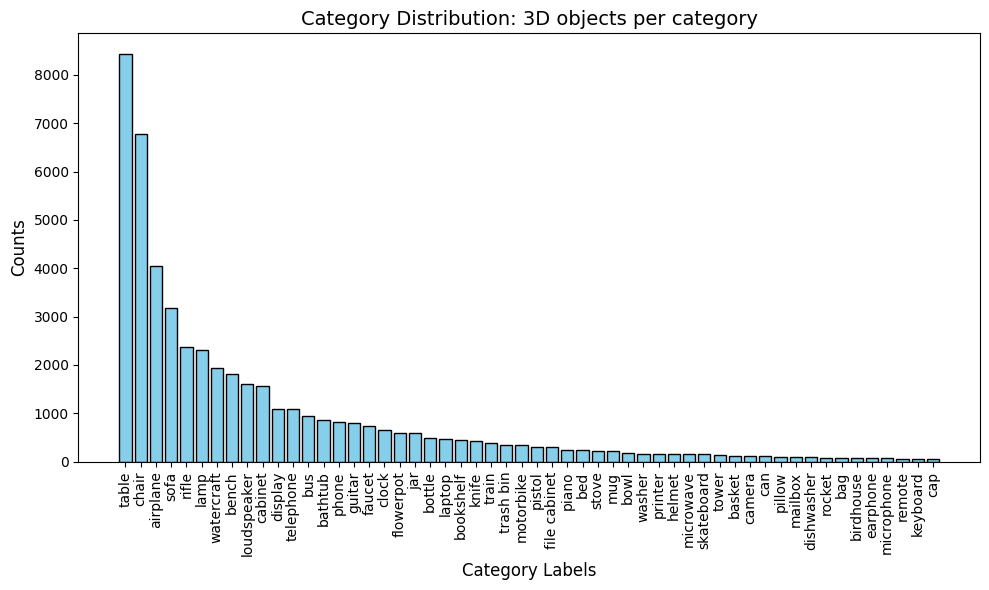

In [124]:
# function to plot the distribution of classes
def plot_barplot(data_dict, title="Bar Plot", xlabel="Labels", ylabel="Counts", ascending=True, top_n=-1):
    data_list = list(sorted(data_dict.items(), key=lambda x : x[1], reverse=not ascending))

    # set how many categories we want to display
    if top_n == -1:
        labels = [x[0] for x in data_list]
        counts = [x[1] for x in data_list]
    else:
        labels = [x[0] for x in data_list][:top_n]
        counts = [x[1] for x in data_list][:top_n]

    # plot the actual bar plot
    plt.bar(labels, counts, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()

plt.figure(figsize=(10, 6))
plot_barplot(category_counts, title="Category Distribution: 3D objects per category", xlabel="Category Labels", ylabel="Counts", ascending=False)

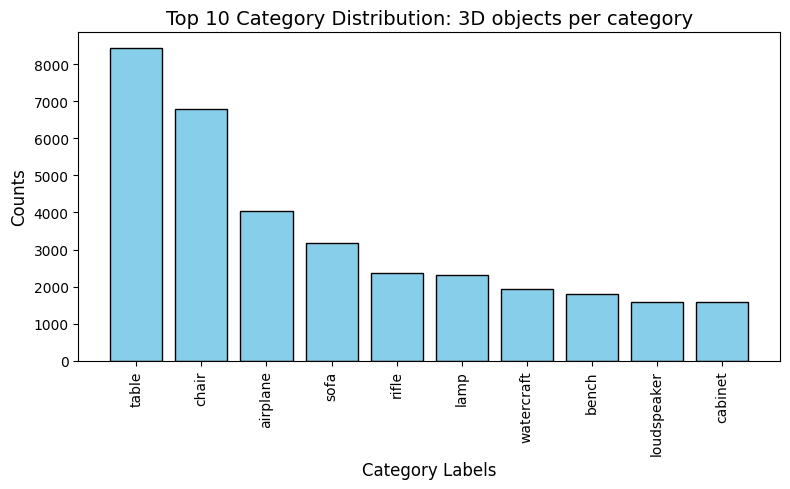

In [82]:
# Show only the top 10
plt.figure(figsize=(8, 5))
plot_barplot(category_counts, title="Top 10 Category Distribution: 3D objects per category", xlabel="Category Labels", ylabel="Counts", ascending=False, top_n=10)

Plot insights:
- From the plot we learn that our categories are __highly imbalanced__.
- Few __14 categories held 50%__ of the total data, while the rest __40 categories held the other 50%__ of the data.
- We need to keep in mind this __class imbalance problem__ when training our CNNs.

### Part IIa. Data Pre-processing (OBJ to NPY pipeline) <a class="anchor" id="part-2a"></a>

Let's __convert our 3D objects into a suitable format__ for CNN training.

First we convert our __OBJ files into voxels__ using the __Trimesh__ library.

Then we save our __voxels into Numpy arrays__, and into NPY files.

Let's save __1 NPY file per category__.

In [43]:
def save_npy_array_from_obj(obj_files, voxel_shape, voxel_resolution=0.025, save_npy=True, npy_filename='voxel_grids'):
    
    # Loop through the OBJ files and initialize an empty array that will contain np arrays
    print("Starting the pipeline...")
    np_arrays = []
    for i, obj_file in enumerate(obj_files):
    
        # Read the mesh from the OBJ file
        mesh = trimesh.load(obj_file, force='mesh')
        
        # Create a voxel grid
        voxelized = mesh.voxelized(pitch=voxel_resolution)
        voxelized = voxelized.revoxelized(shape=voxel_shape)
        voxel_matrix = voxelized.matrix
        
        # Reshape the array to (voxel_shape, 1)
        new_shape = tuple(list(voxel_shape) + [1])
        voxel_matrix = voxel_matrix.reshape(new_shape)
        np_arrays.append(voxel_matrix)
        if i%20 == 0:
            print(f"{round(100*i/len(obj_files), 1)}%", end=" ")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"Final NumPy array shape: {np_arrays_stacked.shape}")

    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

# Save the paths of each of the OBJ files into a list
DATA_PATH = r"D:\_Projects\ShapeNetCore"
obj_files = get_obj_files(DATA_PATH)

Found 48958 OBJ files.


In [71]:
# Convert OBJ files of the 1st category into voxel grids, and save them into a Numpy array
DATA_PATH = r"D:\_Projects\ShapeNetCore\02691156"
obj_files = get_obj_files(DATA_PATH)
save_npy_array_from_obj(obj_files, (32, 32, 32), voxel_resolution=0.025)

Found 4045 OBJ files.
Starting the pipeline...
0.0% 0.5% 1.0% 1.5% 2.0% 2.5% 3.0% 3.5% 4.0% 4.4% 4.9% 5.4% 5.9% 6.4% 6.9% 7.4% 7.9% 8.4% 8.9% 9.4% 9.9% 10.4% 10.9% 11.4% 11.9% 12.4% 12.9% 13.3% 13.8% 14.3% 14.8% 15.3% 15.8% 16.3% 16.8% 17.3% 17.8% 18.3% 18.8% 19.3% 19.8% 20.3% 20.8% 21.3% 21.8% 22.2% 22.7% 23.2% 23.7% 24.2% 24.7% 25.2% 25.7% 26.2% 26.7% 27.2% 27.7% 28.2% 28.7% 29.2% 29.7% 30.2% 30.7% 31.1% 31.6% 32.1% 32.6% 33.1% 33.6% 34.1% 34.6% 35.1% 35.6% 36.1% 36.6% 37.1% 37.6% 38.1% 38.6% 39.1% 39.6% 40.0% 40.5% 41.0% 41.5% 42.0% 42.5% 43.0% 43.5% 44.0% 44.5% 45.0% 45.5% 46.0% 46.5% 47.0% 47.5% 48.0% 48.5% 48.9% 49.4% 49.9% 50.4% 50.9% 51.4% 51.9% 52.4% 52.9% 53.4% 53.9% 54.4% 54.9% 55.4% 55.9% 56.4% 56.9% 57.4% 57.8% 58.3% 58.8% 59.3% 59.8% 60.3% 60.8% 61.3% 61.8% 62.3% 62.8% 63.3% 63.8% 64.3% 64.8% 65.3% 65.8% 66.3% 66.7% 67.2% 67.7% 68.2% 68.7% 69.2% 69.7% 70.2% 70.7% 71.2% 71.7% 72.2% 72.7% 73.2% 73.7% 74.2% 74.7% 75.2% 75.6% 76.1% 76.6% 77.1% 77.6% 78.1% 78.6% 79.1% 79.6% 80

In [72]:
def save_npy_array_from_obj_per_category(data_path, voxel_shape, voxel_resolution=0.025, n_categories=None):

    # Get the category names (55)
    categories = get_category_names(data_path)
    print(f"Found {len(categories)} categories.")
    if n_categories is not None:
        categories = categories[:n_categories]

    # Loop through the categories
    for i, category in enumerate(categories):
        print(f"================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all obj files
        category_path = data_path + '\\' + category
        obj_files = get_obj_files(category_path, recursive=True)
        
        # Convert OBJ files into voxel grids, and save them into a Numpy array
        save_npy_array_from_obj(obj_files, voxel_shape, voxel_resolution, save_npy=True, npy_filename=category+"_voxels")

data_path = r"D:\_Projects\ShapeNetCore"
save_npy_array_from_obj_per_category(data_path, (32, 32, 32), n_categories=1)

Found 54 categories.
================ Starting process for category #1, name: 02691156 ================
Found 4045 OBJ files.
Starting the pipeline...
0.0% 0.5% 1.0% 1.5% 2.0% 2.5% 3.0% 3.5% 4.0% 4.4% 4.9% 5.4% 5.9% 6.4% 6.9% 7.4% 7.9% 8.4% 8.9% 9.4% 9.9% 10.4% 10.9% 11.4% 11.9% 12.4% 12.9% 13.3% 13.8% 14.3% 14.8% 15.3% 15.8% 16.3% 16.8% 17.3% 17.8% 18.3% 18.8% 19.3% 19.8% 20.3% 20.8% 21.3% 21.8% 22.2% 22.7% 23.2% 23.7% 24.2% 24.7% 25.2% 25.7% 26.2% 26.7% 27.2% 27.7% 28.2% 28.7% 29.2% 29.7% 30.2% 30.7% 31.1% 31.6% 32.1% 32.6% 33.1% 33.6% 34.1% 34.6% 35.1% 35.6% 36.1% 36.6% 37.1% 37.6% 38.1% 38.6% 39.1% 39.6% 40.0% 40.5% 41.0% 41.5% 42.0% 42.5% 43.0% 43.5% 44.0% 44.5% 45.0% 45.5% 46.0% 46.5% 47.0% 47.5% 48.0% 48.5% 48.9% 49.4% 49.9% 50.4% 50.9% 51.4% 51.9% 52.4% 52.9% 53.4% 53.9% 54.4% 54.9% 55.4% 55.9% 56.4% 56.9% 57.4% 57.8% 58.3% 58.8% 59.3% 59.8% 60.3% 60.8% 61.3% 61.8% 62.3% 62.8% 63.3% 63.8% 64.3% 64.8% 65.3% 65.8% 66.3% 66.7% 67.2% 67.7% 68.2% 68.7% 69.2% 69.7% 70.2% 70.7% 71.2% 

Now that our 3D objects are converted into a structure format suitable for CNN training,

we can proceed with the next step of pre-processing.

### Part IIb. Data Pre-processing (Render Images pipeline) <a class="anchor" id="part-2b"></a>

Let's __render images from our 3D objects__.

To render we use an __edited version__ of the __Stanford-ShapeNet-Renderer tool__.

This tool version developed by our team __meets our data structure__ and can be found in our GitHub repository.

__Blender 2.90__ is the main open-source software used in the background to render the images.

In [73]:
def render_images_from_obj_files(obj_files, renderer_git_path, n_views, output_path, randomize_view, start_id=0):
    
    # Save current path and change to the stanford-shapenet-renderer tool path
    current_path = os.getcwd()
    os.chdir(renderer_git_path)
    
    # For each OBJ file, generate the images using the renderer tool
    print("Starting the pipeline (generating images)...")
    for i, obj_file in enumerate(obj_files):
        # Print progress
        if i%20 == 0:
            print(f"{round(100*i/len(obj_files), 1)}%", end=" ")

        # Build and execute the blender command to render images using SSR
        command_str = f'blender --background --python render_blender.py -- --views {n_views} --id_render {start_id+i+1} --randomize_view {int(randomize_view)} --output_folder {output_path} {obj_file}'
        os_return = os.system(command_str)
        
        # Check if process was executed succesfully
        if os_return != 0:
            print(f"Error... os returned: {os_return}")
            break
            
    # Return to the original path
    os.chdir(current_path)

def render_images_per_category(categories, n_views, renderer_path, data_path, output_path, randomize_view=False, n_categories=None):
    print(f"Found {len(categories)} categories.")
    # Segment number of categories if required
    if n_categories is not None:
        categories = categories[:n_categories]
        
    # Loop through each of the categories
    for i, category in enumerate(categories):
        print(f"\n================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all obj files
        category_path = data_path + '\\' + category
        obj_files = get_obj_files(category_path, recursive=True)
        
        # Render the images according to the parameters
        render_images_from_obj_files(obj_files, renderer_path, n_views, output_path + "/" + category, randomize_view)

data_path = r"D:\_Projects\ShapeNetCore"
renderer_path = r"D:\_Projects\stanford-shapenet-renderer"
output_path = "/_Projects/ShapeNetCore-Images"
render_images_per_category(categories, 10, renderer_path, data_path, output_path, randomize_view=False, n_categories=1)

Found 54 categories.

================ Starting process for category #1, name: 02691156 ================
Found 4045 OBJ files.
Starting the pipeline (generating images)...
0.0% 0.5% 1.0% 1.5% 2.0% 2.5% 3.0% 3.5% 4.0% 4.4% 4.9% 5.4% 5.9% 6.4% 6.9% 7.4% 7.9% 8.4% 8.9% 9.4% 9.9% 10.4% 10.9% 11.4% 11.9% 12.4% 12.9% 13.3% 13.8% 14.3% 14.8% 15.3% 15.8% 16.3% 16.8% 17.3% 17.8% 18.3% 18.8% 19.3% 19.8% 20.3% 20.8% 21.3% 21.8% 22.2% 22.7% 23.2% 23.7% 24.2% 24.7% 25.2% 25.7% 26.2% 26.7% 27.2% 27.7% 28.2% 28.7% 29.2% 29.7% 30.2% 30.7% 31.1% 31.6% 32.1% 32.6% 33.1% 33.6% 34.1% 34.6% 35.1% 35.6% 36.1% 36.6% 37.1% 37.6% 38.1% 38.6% 39.1% 39.6% 40.0% 40.5% 41.0% 41.5% 42.0% 42.5% 43.0% 43.5% 44.0% 44.5% 45.0% 45.5% 46.0% 46.5% 47.0% 47.5% 48.0% 48.5% 48.9% 49.4% 49.9% 50.4% 50.9% 51.4% 51.9% 52.4% 52.9% 53.4% 53.9% 54.4% 54.9% 55.4% 55.9% 56.4% 56.9% 57.4% 57.8% 58.3% 58.8% 59.3% 59.8% 60.3% 60.8% 61.3% 61.8% 62.3% 62.8% 63.3% 63.8% 64.3% 64.8% 65.3% 65.8% 66.3% 66.7% 67.2% 67.7% 68.2% 68.7% 69.2% 69.

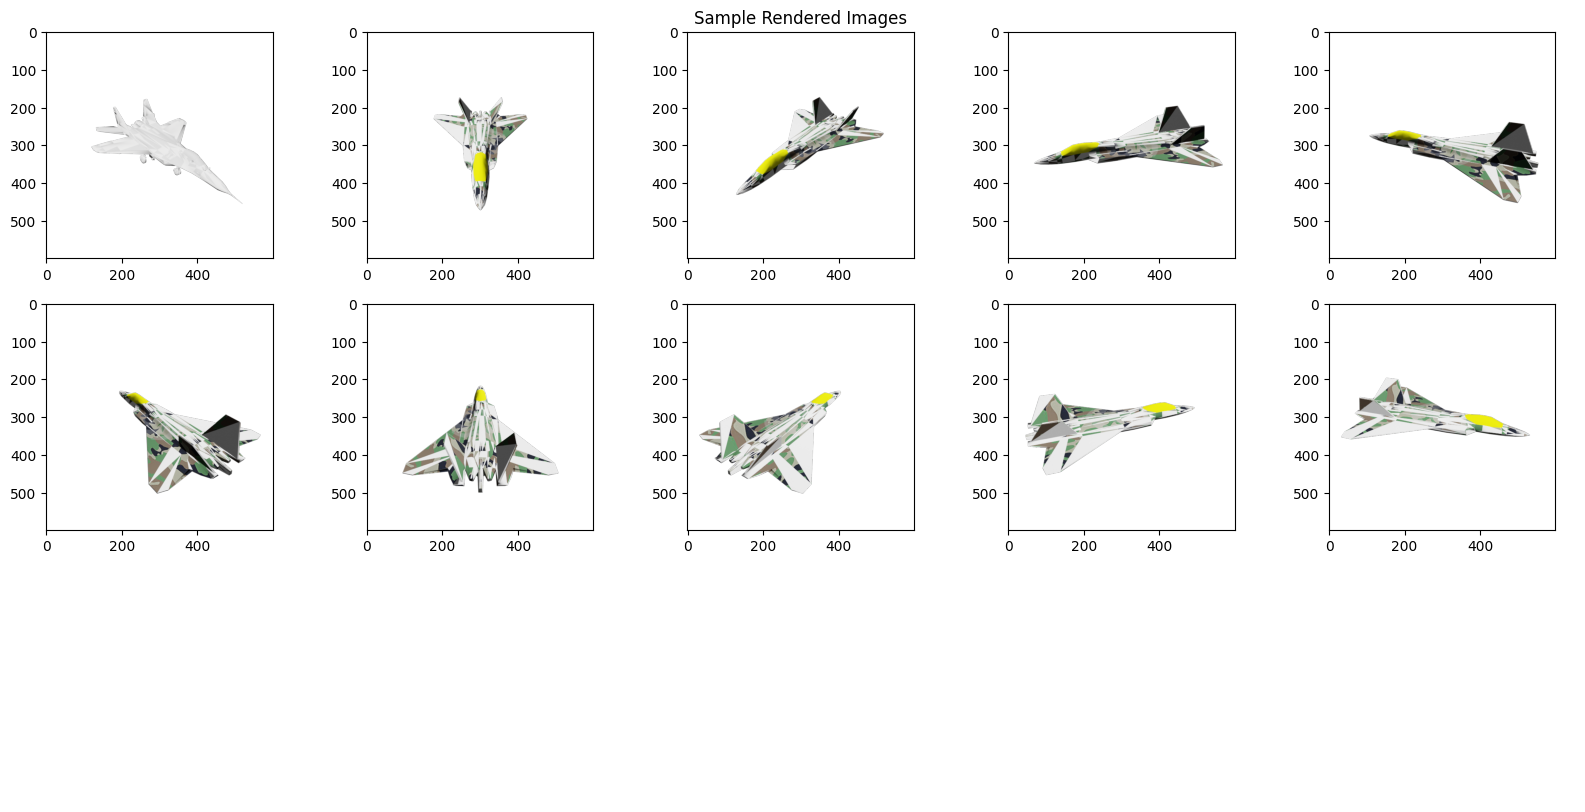

In [50]:
import glob
import random

# Plot random sampled images from the rendered images
def plot_sample_images(data_path, sample_size):
    images = list(glob.glob(data_path))
    random_index = random.randint(0, len(images)- sample_size)
    samples = images[random_index: random_index + sample_size]
    
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.title("Sample Rendered Images")
    columns = 5
    for i, image_path in enumerate(samples):
        ax = plt.subplot(len(samples) // columns + 1, columns, i + 1)
        image = plt.imread(image_path)
        # plt.axis('off')
        plt.imshow(image)

# Set data path, number of sample images, and run the function
data_path = "D:/_Projects/ShapeNetCore-Images/02691156/models/*"
sample_size = 10
plot_sample_images(data_path, sample_size)

### Part IIc. Data Pre-processing (PNG to NPY pipeline) <a class="anchor" id="part-2c"></a>

Now that our __images have been rendered__, let's proceed with pre-processing.

We will __convert images into a suitable format for CNN training__, hence Numpy arrays.

Our initial proposed __resolution__ for the post-processed images is __128x128__, to avoid heavy data size while keeping the most important image features.

Let's build a __pipeline to convert all images into NPY files__ ready for training.

In [55]:
def get_png_files(data_path, recursive=True):
    
    # Retrieve PNG files from the data path
    png_files = [file for file in glob.glob(data_path + r"\**\*.png", recursive=recursive)]
    print(f"Found {len(png_files)} PNG files.")
    return png_files

def save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename='images'):
    
    # Loop through the PNG files and initialize an empty array that will contain np arrays
    print("Starting pipeline...")
    np_arrays = []
    curr_progress, prev_progress = 0.0, -0.5
    for i, png_file in enumerate(png_files):

        # Open the image and convert into grayscale
        img = Image.open(png_file)
        img_gray = img.convert("L")
        
        # Resize the image to the desired shape and into a numpy array
        img_resized = img_gray.resize(image_shape)
        img_array = np.array(img_resized)
        
        # Reshape the array to (image shape, 1)
        new_shape = tuple(list(image_shape) + [1])
        img_array = img_array.reshape(new_shape)
        np_arrays.append(img_array)
        
        # Print progress, but not on every loop
        curr_progress = round(100 * (i+1) / len(png_files), 2)
        if (curr_progress - prev_progress) >= 0.5:
            prev_progress = float(curr_progress)
            print(f"{curr_progress}%", end=" ")
            if curr_progress != 0.0 and curr_progress % 10.0 == 0:
                print(f"({i+1} files done)")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"\nFinal NumPy array shape: {np_arrays_stacked.shape}")
    
    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

def save_npy_array_from_png_per_category(data_path, image_shape, n_categories=None):
    
    # Get the category names
    categories = get_category_names(data_path)
    if n_categories is not None:
        categories = categories[:n_categories]

    # Loop through the categories
    for i, category in enumerate(categories):
        print(f"================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all images in PNG format
        category_path = data_path + '\\' + category
        png_files = get_png_files(category_path, recursive=True)
        
        # Fixing the image files order due to naming error during generation, now files are in proper id order
        png_files = list(sorted(png_files, key=lambda x: int(x.split('\\')[-1].split('_')[2])))

        # Convert PNG files into Numpy arrays
        save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename=category+"_images")

# Read all images, convert them into a proper format, and save them into a Numpy array
data_path = r"D:\_Projects\ShapeNetCore-Images"
resolution = (128, 128)
save_npy_array_from_png_per_category(data_path, resolution, n_categories=1)

================ Starting process for category #1, name: 02691156 ================
Found 40450 PNG files.
Starting pipeline...
0.0% 0.5% 1.0% 1.5% 2.0% 2.5% 3.0% 3.5% 4.0% 4.5% 5.0% 5.5% 6.0% 6.5% 7.0% 7.5% 8.0% 8.5% 9.0% 9.5% 10.0% (4043 files done)
10.5% 11.0% 11.5% 12.0% 12.5% 13.0% 13.5% 14.0% 14.5% 15.0% 15.5% 16.0% 16.5% 17.0% 17.5% 18.0% 18.5% 19.0% 19.5% 20.0% (8088 files done)
20.5% 21.0% 21.5% 22.0% 22.5% 23.0% 23.5% 24.0% 24.5% 25.0% 25.5% 26.0% 26.5% 27.0% 27.5% 28.0% 28.5% 29.0% 29.5% 30.0% (12133 files done)
30.5% 31.0% 31.5% 32.0% 32.5% 33.0% 33.5% 34.0% 34.5% 35.0% 35.5% 36.0% 36.5% 37.0% 37.5% 38.0% 38.5% 39.0% 39.5% 40.0% (16178 files done)
40.5% 41.0% 41.5% 42.0% 42.5% 43.0% 43.5% 44.0% 44.5% 45.0% 45.5% 46.0% 46.5% 47.0% 47.5% 48.0% 48.5% 49.0% 49.5% 50.0% (20223 files done)
50.5% 51.0% 51.5% 52.0% 52.5% 53.0% 53.5% 54.0% 54.5% 55.0% 55.5% 56.0% 56.5% 57.0% 57.5% 58.0% 58.5% 59.0% 59.5% 60.0% (24268 files done)
60.5% 61.0% 61.5% 62.0% 62.5% 63.0% 63.5% 64.0% 64.5% 6

### Part III. Splitting the dataset & Final Pre-processing <a class="anchor" id="#part-3"></a>

Now that we have the __input and output data into a suitable format for CNN training__ let's proceed to last steps of pre-processing.

This last step consists in __building a function__ to build final Numpy arrays ready for passing to the CNN models.

This function will __load the saved NPY files__ to __build__ a custom (parameter-based) shape __Numpy array based on the number of images (per 3D object)__ we want to use.

Since we rendered 10 images per model we have the option to work with 1, 2, 3, ... __up to 10 images per 3D object__ and compare results.

This function will allow us to easily build the Numpy arrays for __any shape that we want to test__, in only 1 function call.

In [5]:
def prepare_data_based_on_images_per_voxel(images_npy, voxels_npy, images_per_voxel):

    if images_per_voxel < 1 or images_per_voxel > 10:
        raise Exception("images_per_voxel should be a positive integer <= 10")

    # Data augmentation on the 3D voxels data if required (due to more image data)
    if images_per_voxel != 1:
        voxels_npy = np.repeat(voxels_npy, repeats=images_per_voxel, axis=0)

    if images_per_voxel == 10:
        return images_npy, voxels_npy
    
    # Data segmentation on the images data if required (due to less voxel data)
    chunk_size = 10
    num_chunks = images_npy.shape[0] // chunk_size
    
    # Initialize empty list of selected images
    selected_images = []
    
    # Loop over each chunk and get start and end of current chunk
    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        
        # Get the indices for equally spaced elements within this chunk, appending the result
        indices = np.linspace(chunk_start, chunk_end - 1, images_per_voxel, dtype=int)
        selected_images.append(images_npy[indices])
    
    # Convert the result list to a NumPy
    images_npy = np.concatenate(selected_images, axis=0)
    
    return images_npy, voxels_npy

print(f"Example Category 02691156: {category_labels['02691156']}")
voxels_npy = np.load('voxels/32/02691156_voxels.npy')
images_npy = np.load('images/128/02691156_images.npy')
print(f"Voxels Numpy Array shape raw: {voxels_npy.shape}")
print(f"Images Numpy Array shape raw: {images_npy.shape}")
images_npy, voxels_npy = prepare_data_based_on_images_per_voxel(images_npy, voxels_npy, 5)
print(f"Voxels Numpy Array shape after processing: {voxels_npy.shape}")
print(f"Images Numpy Array shape after processing: {images_npy.shape}")
del images_npy
del voxels_npy

Example Category 02691156: airplane
Voxels Numpy Array shape raw: (4045, 32, 32, 32, 1)
Images Numpy Array shape raw: (40450, 128, 128, 1)
Voxels Numpy Array shape after processing: (20225, 32, 32, 32, 1)
Images Numpy Array shape after processing: (20225, 128, 128, 1)


Now that the __number of instances for images and 3D shapes are equal__,

we can __proceed to splitting the data__ into subsets of test, and training.

Implementing one __function with customizable parameters__ will help us in later experiments.

In [6]:
from sklearn.model_selection import train_test_split

def split_data(category, input_shape, output_shape, images_per_voxel, test_size, validation_size, perc_data_used=1):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Load the numpy arrays (input and output)
    images = np.load(f'images/{input_reso}/{category}_images.npy')
    voxels = np.load(f'voxels/{output_reso}/{category}_voxels.npy')

    # Prepare data based on required images per 3D object
    images, voxels = prepare_data_based_on_images_per_voxel(images, voxels, images_per_voxel)

    # Split into test and train subsets
    x, x_val, y, y_val = train_test_split(images, voxels, test_size=validation_size)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

    # Optionally work with only a percentage of the data for test & train, but include all data (100%) by default
    if perc_data_used != 1:
        l_train, l_test = len(x_train), len(x_test)
        s_train, s_test = int(l_train * perc_data_used), int(l_test * perc_data_used)
        x_train, x_test, y_train, y_test = x_train[:s_train], x_test[:s_test], y_train[:s_train], y_test[:s_test]
    
    return x_train, x_test, x_val, y_train, y_test, y_val

# Split data from 1 category to validate function
test_size=0.3
validation_size=0.05
x_train, x_test, x_val, y_train, y_test, y_val = split_data('02691156',
                                                            input_shape=(128, 128, 1),
                                                            output_shape=(32, 32, 32, 1),
                                                            images_per_voxel=5,
                                                            test_size=test_size,
                                                            validation_size=validation_size)
print(f"Used {100*test_size}% for test subset and {100*validation_size}% for validation set.")
print(f"X train shape: {x_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"X validation shape: {x_val.shape}")
print(f"Y train shape: {y_train.shape}")
print(f"Y test shape: {y_test.shape}")
print(f"Y validation shape: {y_val.shape}")

Used 30.0% for test subset and 5.0% for validation set.
X train shape: (13449, 128, 128, 1)
X test shape: (5764, 128, 128, 1)
X validation shape: (1012, 128, 128, 1)
Y train shape: (13449, 32, 32, 32, 1)
Y test shape: (5764, 32, 32, 32, 1)
Y validation shape: (1012, 32, 32, 32, 1)


Our function succesfully splits the data.

Before training any model, let's __implement some helper functions__:

- __Clear RAM__: we need free RAM constantly to avoid exhausting computing resources too fast
- __Saving Dictionary as a file__: to save model metrics (history) during training

In [7]:
from keras.backend import clear_session
import gc
import pickle

def clear_ram():
    clear_session()
    gc.collect()

def save_dictionary_as_pickle(initial_path, filename, dictionary):
    # Save dictionary
    with open(initial_path + filename, 'wb+') as f:
        pickle.dump(dictionary, f)

test_dict = {}
saved_ram = clear_ram()
saved_ram = 0 if saved_ram is None else saved_ram 
print(f"- Cleared {saved_ram} KB of RAM")
file_name = 'test_dictionary.pkl'
save_dictionary_as_pickle('.', file_name, test_dict)
print(f"- Saved {type(test_dict)} as {file_name}")

- Cleared 0 KB of RAM
- Saved <class 'dict'> as test_dictionary.pkl


## Part IV. Developing the CNN architecture, Training and testing (Base model) <a class="anchor" id="#part-4"></a>

We can finally start __engineering our CNN architecture__.

This will be a __trial-error approach__ with multiple architectures and data __parameters to test__.

For this task we are working with __keras Sequential model and layers__.

We will test with the following layers:
- Start by adding __2D Convolutional layers__.
- Then we __flatten__ our output and add __dense layers__ before reshaping into a 3D space.
- Finally, we add __3D Convolutional layers__ to enhance the 3D spatial results

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv3D, Dense, Flatten, Reshape, Conv2DTranspose

def build_cnn_model(input_shape, output_shape):    
    # Define the model
    model = Sequential()
    
    # 2D convolutional layers (feature extraction from images)
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=2, padding='same'))  # Downsample to 64x64
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(32 * 32 * 32, activation='relu'))  # Fully connected layer for 3D mapping
    
    # Reshape to 3D
    model.add(Reshape(output_shape))
    
    # 3D convolutional layers
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Output layer
    return model

# Print the summary
with tf.device('/CPU:0'):
    model = build_cnn_model((128, 128, 1), (32, 32, 32, 1))
    display(model.summary())
    del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 1024)              536871936 
                                                                 
 dense_1 (Dense)             (None, 32768)             3

None

From the model summary we learn that our model has __570 million parameters__.

This indicates that our model is __complex__ and has very __high capacity__.

Before training, let's actually implement:

- __Early Stopping__: this will help us __save time and computing resources__ when the validation loss is not improving for a 'patience' amount of epochs
- __Model Checkpoint__: will keep the best model (based on metrics) saved as a __keras file__

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model_one_category(category,
                             x_train, x_test, y_train, y_test,
                             input_shape,
                             output_shape,
                             epochs,
                             batch_size,
                             use_es=True, # should the model use early stopping
                             use_mc=True): # should the model save checkpoints
    
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Instantiate and compile the model
    model = build_cnn_model(input_shape, output_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])        
    
    # Early Stopping
    es = EarlyStopping(monitor='val_loss',
                       mode='min',
                       verbose=1,
                       patience=5,
                       restore_best_weights=True)

    # Model Checkpoint
    mc = ModelCheckpoint(filepath=f'models/{input_reso}x{output_reso}/{category}.keras',
                         monitor='val_loss',
                         mode='max',
                         verbose=1,
                         save_best_only=True,
                         )

    # Set the callbacks
    callbacks = []
    if use_es: callbacks.append(es)
    if use_mc: callbacks.append(mc)

    # Train Model based on given parameters
    model_history = model.fit(x_train,
                              y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(x_test, y_test),
                              verbose=1,
                              callbacks=callbacks)
    return model, model_history

For our __model compilation__ we have used the __following metrics__, here's why:
- __loss: binary cross entropy__
    * Why? Because we are dealing with binary outputs that indicate presence/absence of a voxel in the 3D shape
- __optimizer: adam__
    * Why? It adapts the learning rate for each parameter, making it effective for large, complex models. It balances performance and efficiency.
- __metrics: accuracy & binary_crossentropy__
    * Why? For binary voxel outputs we need to measure not only validation accuracy but binary cross entropy that deals with presence/absence of data.

For the __Early Stopping and Model Checkpoint__ we have chose to __monitor__:
- __val_loss__
    * Why? Because Binary Crossentropy (loss='binary_crossentropy') is our primary loss function, so tracking val_loss ensures the model generalizes well on unseen data.
    * Why not accuracy? Accuracy is helpful for monitoring but can sometimes plateau or improve slightly even if the model overfits

Our function to train a model using 1 category is capable of __customize the following parameters__:
- __input_shape__: image resolution
- __output_shape__: voxel resolution
- __epochs__: number of max epochs to train the model
- __batch_size__: number of instances used to calculate 1 gradient descent instance
- __callbacks__: use early stopping and/or model checkpoints

Let's test this function by training a __base model for testing on a random category__.

In [12]:
input_shape=(128, 128, 1)
output_shape=(32, 32, 32, 1)
x_train, x_test, x_val, y_train, y_test, y_val = split_data('02691156',
                                                            input_shape,
                                                            output_shape,
                                                            images_per_voxel=1,
                                                            test_size=0.3,
                                                            validation_size=0.05)
model, model_history = train_model_one_category('02691156',
                                                x_train,
                                                x_test,
                                                y_train,
                                                y_test,
                                                input_shape,
                                                output_shape,
                                                epochs=20,
                                                batch_size=32)

Epoch 1/20
85/85 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9047 - binary_crossentropy: 0.2037
Epoch 1: val_loss improved from -inf to 0.15871, saving model to models/128x32\02691156.keras
85/85 [==============================] - 127s 1s/step - loss: 0.2037 - accuracy: 0.9047 - binary_crossentropy: 0.2037 - val_loss: 0.1587 - val_accuracy: 0.9306 - val_binary_crossentropy: 0.1587
Epoch 2/20
85/85 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9322 - binary_crossentropy: 0.1538
Epoch 2: val_loss did not improve from 0.15871
85/85 [==============================] - 26s 298ms/step - loss: 0.1538 - accuracy: 0.9322 - binary_crossentropy: 0.1538 - val_loss: 0.1502 - val_accuracy: 0.9356 - val_binary_crossentropy: 0.1502
Epoch 3/20
85/85 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9355 - binary_crossentropy: 0.1436
Epoch 3: val_loss did not improve from 0.15871
85/85 [==============================] - 26s 303ms

Our __base model__ was set for 20 epochs but the __early stopping__ triggered at __epoch 10__.

This means that the __validation loss didn't improve for the last 5 epochs__.

Now that our base model is trained, let's __implement functions to validate the model__ and watch its __performance__ over time.

### Part V. Validating the Model and Metrics: IoU, Accuracy, Loss, Visual Comparisons (Base model) <a class="anchor" id="#part-5"></a>

Let's start by __plotting the model history__ over time (for __each epoch__).

The __metrics__ shown will be __accuracy and loss__ (__binary cross entropy__).

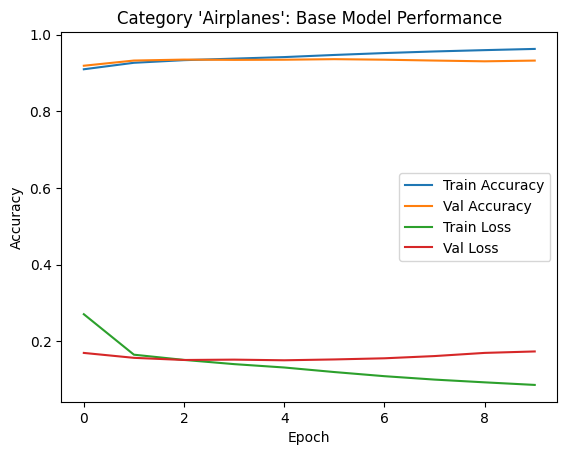

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_performance(model_history, title, filename):
    
    # Plot the model history
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])

    # Set the labels, title, and legend, and save the picture
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])
    plt.savefig(filename)
    plt.show()

plot_model_performance(model_history = model_history,
                       title="Category 'Airplanes': Base Model Performance",
                       filename='test.png')

From the plot we see that the __validation accuracy and loss__ (binary crossentropy) metrics have __not significantly changed__ in the last 5 epochs.

Now, let's __implement a function to validate the model__ using __validation subset of data__.

This __validation set__ represents __5% of our data__ that we splitted initially and our model has never used before.

We will make __predictions__ on this data and __visualize__ the __metrics__.

Metrics are: __loss, accuracy, binary_crossentropy__

In [10]:
from keras.models import load_model

def load_model_from_file(input_shape, output_shape, images_per_voxel, category):
    
    # Load the model of the category, saved as keras file
    return load_model(f'models/{images_per_voxel}x{input_shape[0]}x{output_shape[0]}/{category}.keras')


def validate_model(model, x_val, y_val, run_on, model_name):        
    # Run on CPU or GPU depending on param
    with tf.device(f'/{run_on}PU:0'):
    
        # Set strings with the input and output reso for file reading
        print(f'Evaluating model on category: {model_name}.')
        
        # Evaluate model with test data
        metrics = model.evaluate(x_val, y_val)

    return metrics

metrics = validate_model(model, x_val, y_val, run_on='G', model_name='airplanes')
metrics

Evaluating best model on category: airplanes.
7/7 [==============================] - 1s 143ms/step - loss: 0.1551 - accuracy: 0.9328 - binary_crossentropy: 0.1551


[0.155095174908638, 0.9327654242515564, 0.155095174908638]

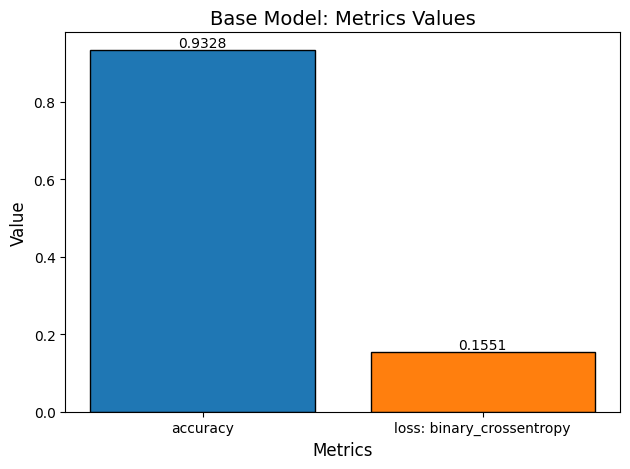

In [11]:
# function to plot a barplot of the metric values from the model evaluated
def plot_barplot_metric_values(metrics):

    # Set colors and bar values
    colors = ['#1f77b4', '#ff7f0e']
    x_values = ['accuracy', 'loss: binary_crossentropy']
    y_values = [metrics[1], metrics[0]]

    # Plot the actual barplot and set titles
    fig, ax = plt.subplots()
    bars = plt.bar(x_values, y_values, color=colors, edgecolor='black')
    plt.title("Base Model: Metrics Values", fontsize=14)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Value', fontsize=12)

    # Annotate bar values
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height,
            f'{height:.4f}',
            ha='center',
            va='bottom'
        )
    plt.tight_layout()
    plt.show()

plot_barplot_metric_values(metrics)

From the plot we learn that:
- Our __accuracy__ reached a value of __93.5%__
- Our __validation loss__ (or __binary cross entropy__) reached a value of __14.85%__

Let's proceed with one more metric that we need to calculate ourselves.

This metric is called __Intersection Over Union (IoU)__, and it is the __ratio__ of the __area of intersection to the area of union__.

This metric __measures the overlap between the predicted space and the ground truth space__ (from the original 3D models).

IoU will indicate us how well the prediction matches the true object.

Let's implement a function to calculate __IoU between 2 voxels__, later we will pass the predicted and original voxels to this function.

We will also need a function to __predict voxels based on images__, from our validation set.

This __validation set__ represents __5% of our data__ that we splitted initially and our model has never used before.

In [13]:
# Predict voxels on unseen data
y_pred = model.predict(x_val)

print(f"Original voxels array shape: {y_val.shape}")
print(f"Predicted voxels array shape: {y_pred.shape}")

7/7 [==============================] - 1s 198ms/step
Original voxels array shape: (203, 32, 32, 32, 1)
Predicted voxels array shape: (203, 32, 32, 32, 1)


In [14]:
# Cast our predicted voxel to boolean values first, with a threshold of 0.5
def post_process_predicted_voxel(y_pred_instance, thresh=0.5):

    return (y_pred_instance > thresh).astype(bool)
    
def calculate_iou(voxel_1, voxel_2):
    # calculate the IOU metric on 2 given voxels as numpy arrays
    voxel_1_bool = post_process_predicted_voxel(voxel_1)
    overlap = voxel_1_bool * voxel_2
    union = voxel_1_bool + voxel_2
    return overlap.sum() / float(union.sum())

def calculate_iou_batch(voxels_batch_1, voxels_batch_2, get_values=False):
    # calculate the average of IOU metrics from each pair of voxels from 2 batches
    num_instances = voxels_batch_1.shape[0]
    ious = []
    sum_iou = 0
    for i in range(num_instances):
        iou = calculate_iou(voxels_batch_1[i], voxels_batch_2[i])
        sum_iou += iou
        ious.append(iou)

    # return a list with all IOUs if required, otherwise return average
    if get_values:
        return ious, sum_iou / num_instances
    return sum_iou / num_instances
    
print(f"IOU on first prediction: {round(calculate_iou(y_pred[0], y_val[0]), 4)}")
print(f"IOU average on entire validation set: {round(calculate_iou_batch(y_pred, y_val), 4)}")

IOU on first prediction: 0.6738
IOU average on entire validation set: 0.4793


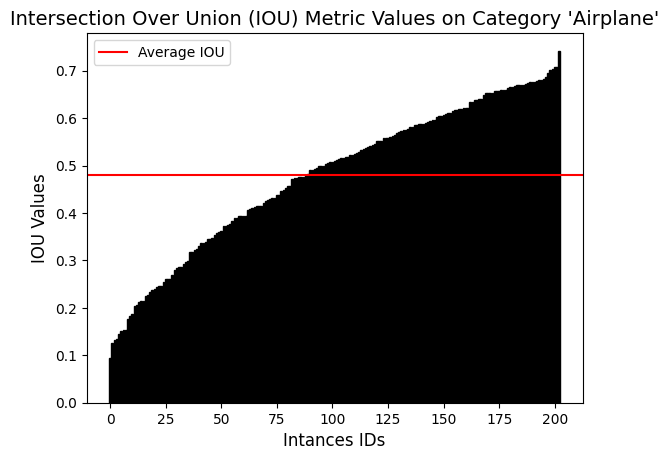

In [18]:
# function to plot calculated IOU metrics including the average
def plot_iou_metrics(ious, avg, category_label):
    plt.bar([i for i in range(len(ious))], sorted(ious), color='black', edgecolor='black')
    plt.axhline(y = avg, color = 'r', linestyle = '-', label="Average IOU") 
    plt.legend()
    plt.title(f"Intersection Over Union (IOU) Metric Values on Category '{category_label}'", fontsize=14)
    plt.xlabel('Intances IDs', fontsize=12)
    plt.ylabel('IOU Values', fontsize=12)
    plt.show()

ious, avg = calculate_iou_batch(y_pred, y_val, get_values=True)
plot_iou_metrics(ious, avg, 'Airplane')

From the __plot__ we learn the following __insights__:

- The __IOU values__ vary __between 0.1 and 0.7__ across all voxels.
- The __average IOU__ is placed around __0.47__
- Our __IOUs vary across a wide range__, this indicates that our model prediction strongly depends on the input.

However, to make any conclusions we would __need to compare__ these results __with other categories__.

For now, let's build our functions for our __last metric: visual comparisons__.

This metric is about __visualizing both predicted and original voxels__ ourselves looking for similarities using human perception.

In [16]:
# Function to save a voxel grid into an OBJ file
def save_voxel_grid_to_obj(voxel_grid, filename):
    # Set vertices and faces for an individual cube
    vertex_offsets = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
        (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)]
    face_offsets = [(0, 1, 2, 3), # bottom
        (4, 5, 6, 7), # top
        (0, 1, 5, 4), # front
        (2, 3, 7, 6), # back
        (1, 2, 6, 5), # right
        (3, 0, 4, 7)]  # left
    vertices, faces = [], []
    vertex_index = 1

    # Iterate through the 3D array, processing each voxel
    for x in range(voxel_grid.shape[0]):
        for y in range(voxel_grid.shape[1]):
            for z in range(voxel_grid.shape[2]):

                # If the current voxel is occupied
                if voxel_grid[x, y, z] != 1:
                    continue
                    
                # Add the vertices for the cube/voxel
                for dx, dy, dz in vertex_offsets:
                    vertices.append((x + dx, y + dy, z + dz))

                # Add the faces for the cube/voxel
                for face in face_offsets:
                    faces.append((
                        vertex_index + face[0],
                        vertex_index + face[1],
                        vertex_index + face[2],
                        vertex_index + face[3]
                    ))

                # Update the vertex index
                vertex_index += 8

    # Write vertices and faces to an OBJ file
    with open(filename, 'w') as obj_file:
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        for face in faces:
            obj_file.write(f"f {face[0]} {face[1]} {face[2]} {face[3]}\n")


In [17]:
# Save both voxel grids (predicted and actual) as OBJ files for visual comparison
def visual_comparison_voxels(y_val, y_pred, indexes, thresh):
    for idx in indexes:
        y_pred_instance = post_process_predicted_voxel(y_pred[idx, :, :, :, 0], thresh)
        save_voxel_grid_to_obj(y_pred_instance, f'y_pred_{idx}.obj')
        save_voxel_grid_to_obj(y_val[idx, :, :, :, 0], f'y_val_{idx}.obj')

visual_comparison_voxels(y_val, y_pred, [1, 15, 30, 75], 0.5)

Let's __display 4 samples__ from our resultant __voxel predictions__ and __compare__ them to the originals.

Once again, these models are __new to the model__.

Sample 1: Actual 3D object


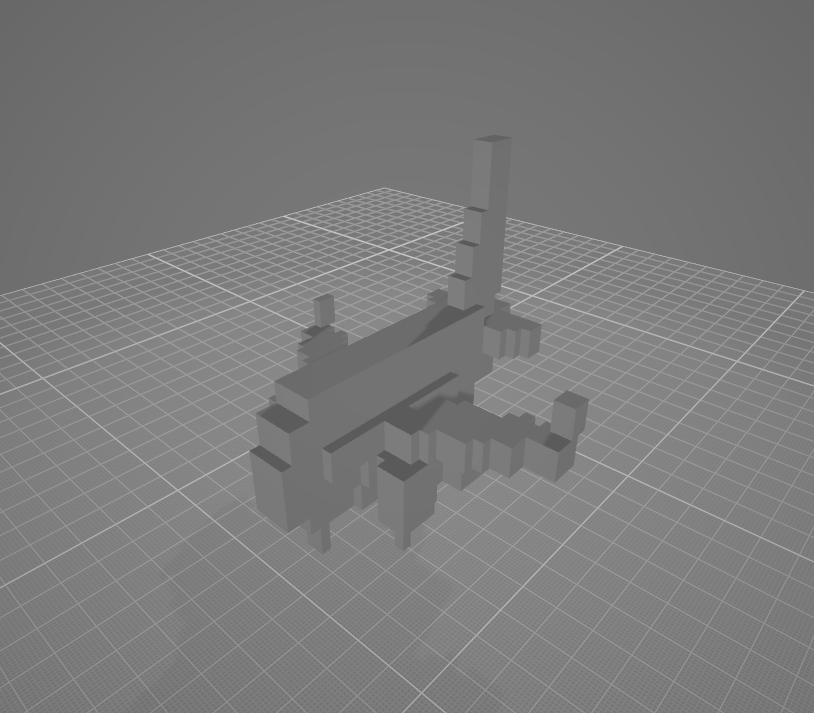

Sample 1 - Predicted 3D object


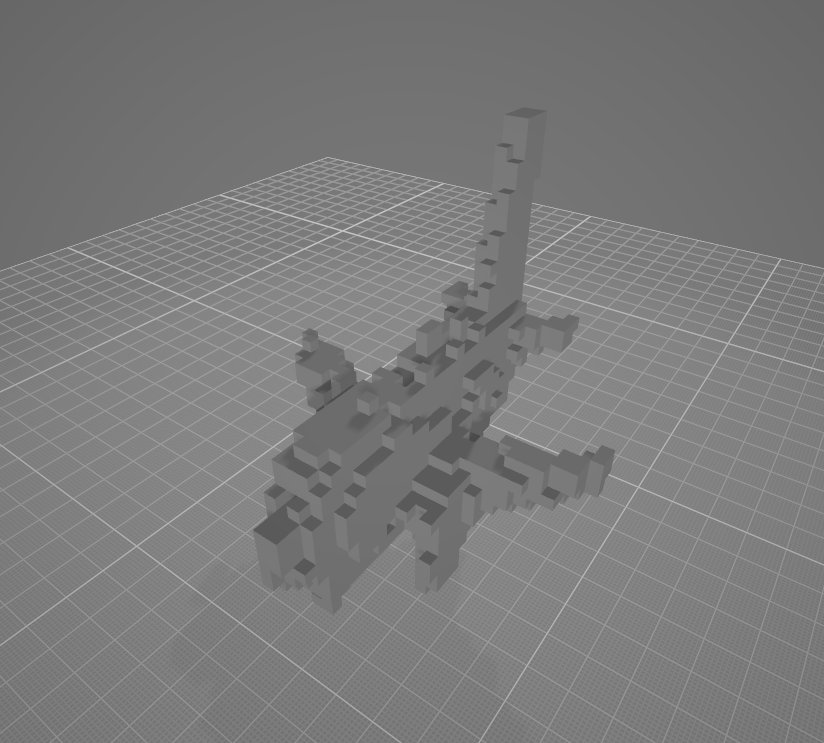



Sample 2: Actual 3D object


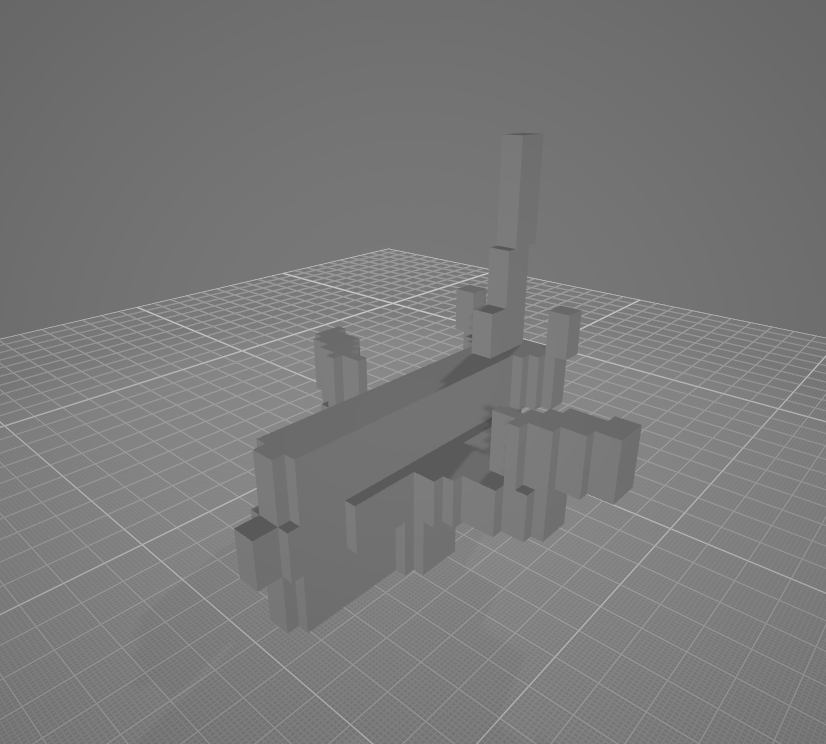

Sample 2 - Predicted 3D object


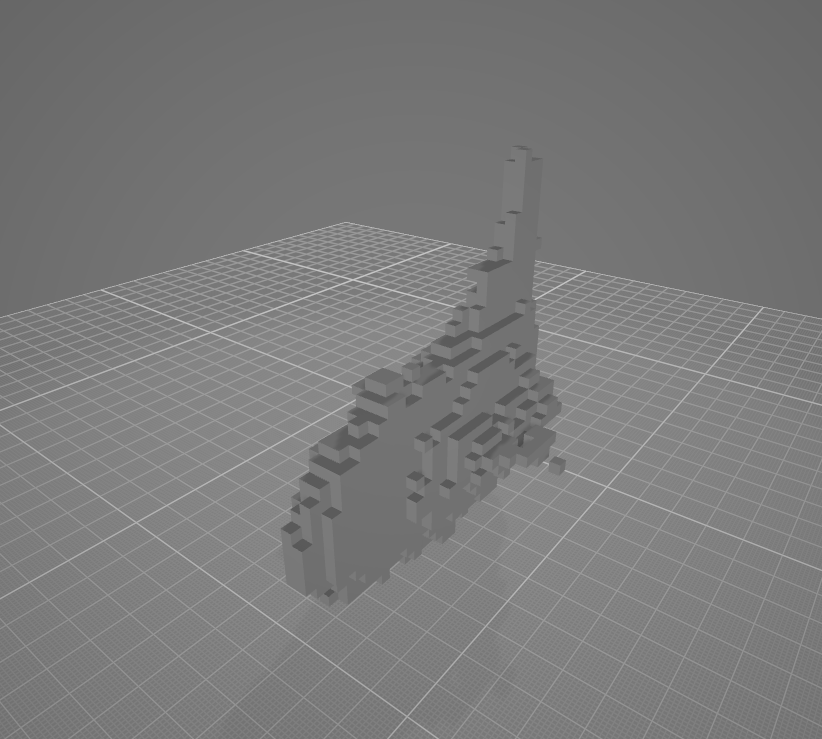



Sample 3: Actual 3D object


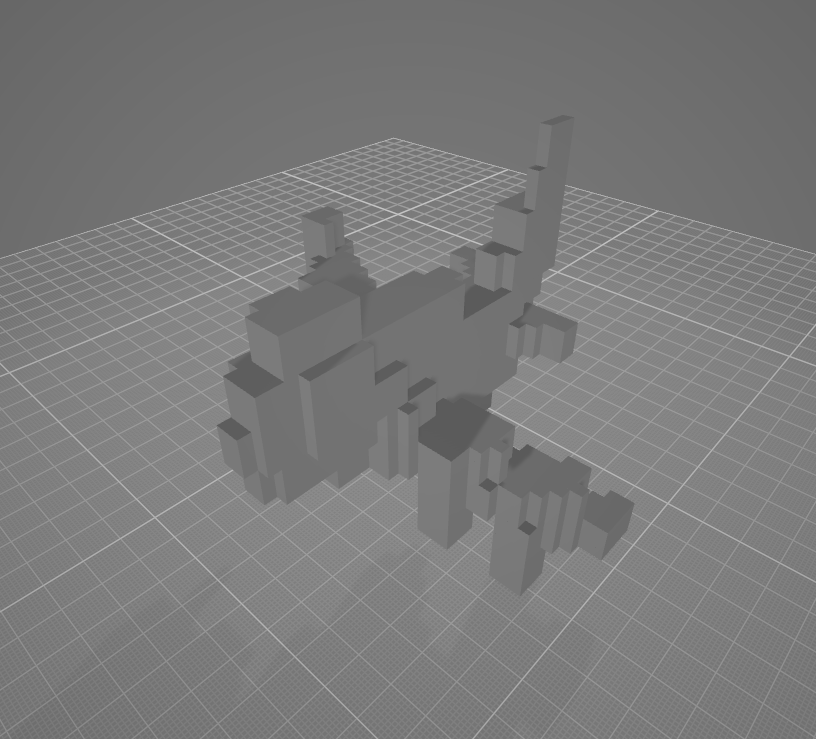

Sample 3 - Predicted 3D object


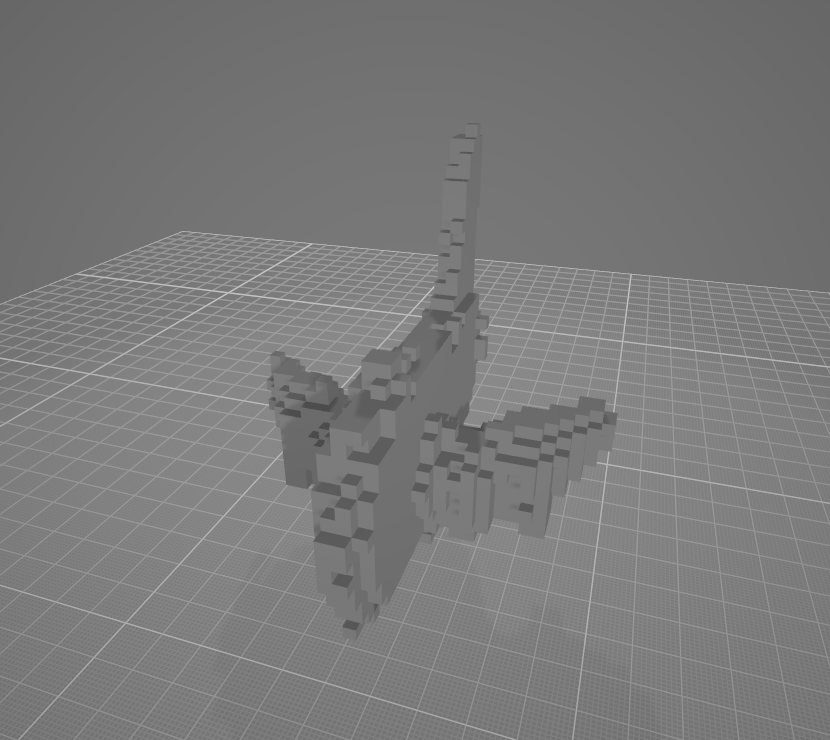



Sample 4: Actual 3D object


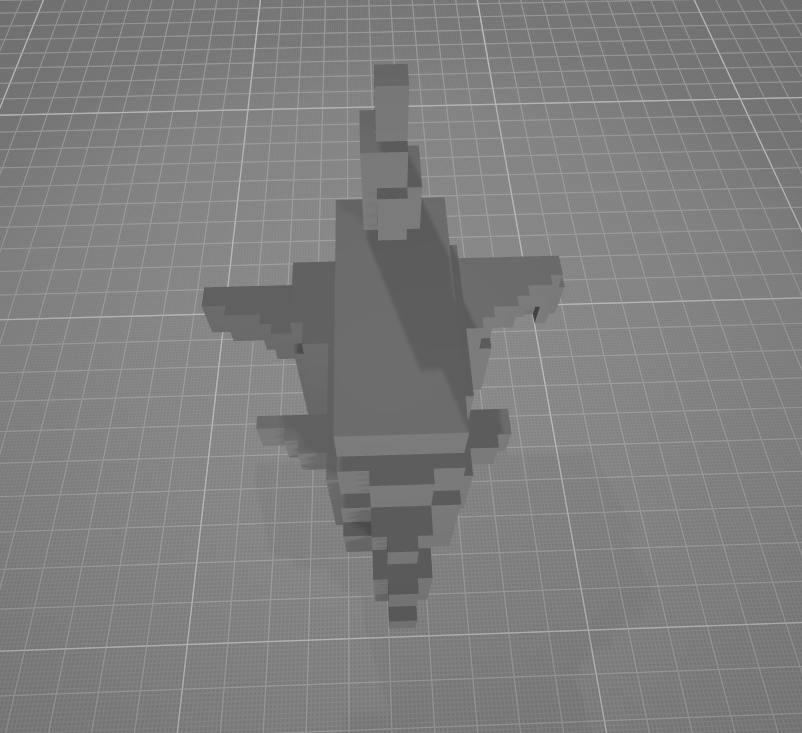

Sample 4 - Predicted 3D object


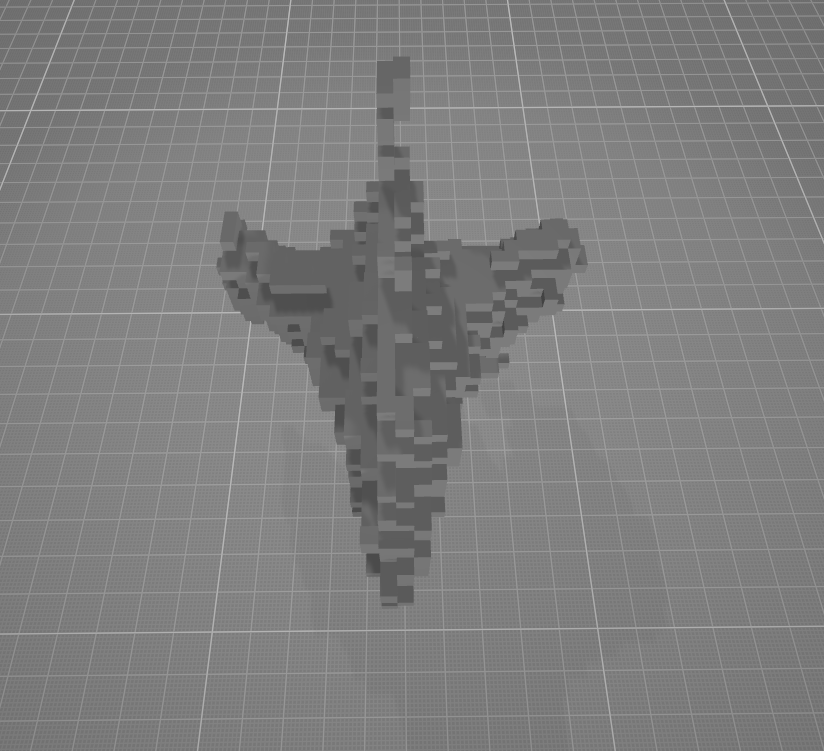

In [113]:
from IPython.display import Image
print("Sample 1: Actual 3D object")
display(Image(filename='visual-comparisons/vc_val_1.png', width = 500))
print("Sample 1 - Predicted 3D object")
display(Image(filename='visual-comparisons/vc_pred_1.png', width = 500))

print("\n\nSample 2: Actual 3D object")
display(Image(filename='visual-comparisons/vc_val_15.png', width = 500))
print("Sample 2 - Predicted 3D object")
display(Image(filename='visual-comparisons/vc_pred_15.png', width = 500))

print("\n\nSample 3: Actual 3D object")
display(Image(filename='visual-comparisons/vc_val_30.png', width = 500))
print("Sample 3 - Predicted 3D object")
display(Image(filename='visual-comparisons/vc_pred_30.png', width = 500))

print("\n\nSample 4: Actual 3D object")
display(Image(filename='visual-comparisons/vc_val_75.png', width = 500))
print("Sample 4 - Predicted 3D object")
display(Image(filename='visual-comparisons/vc_pred_75.png', width = 500))

From the images we can conclude that:
- The __predicted voxels__ are __visually correlated__ to their original 3D objects
- Our __predicted voxels__ are having more distorsion and __less smoother surfaces.__

Now that we have __finished building data pipelines, training functions, and validation methods__,

let's __start training our models__ from the actual big data that we have available.

## Part VIa. Developing the CNN architecture, Training and testing (High-capacity models) <a class="anchor" id="#part-6a"></a>

Due to our class imbalance, we have decided to work with __different CNN architectures depending on the size of the data__.

This will allow us to use __high-capacity complex CNN for the largest datasets__.

While, using medium-capacity and __low-capacity CNNs for smaller datasets__.

Let's __visualize our data division__ based on data size.

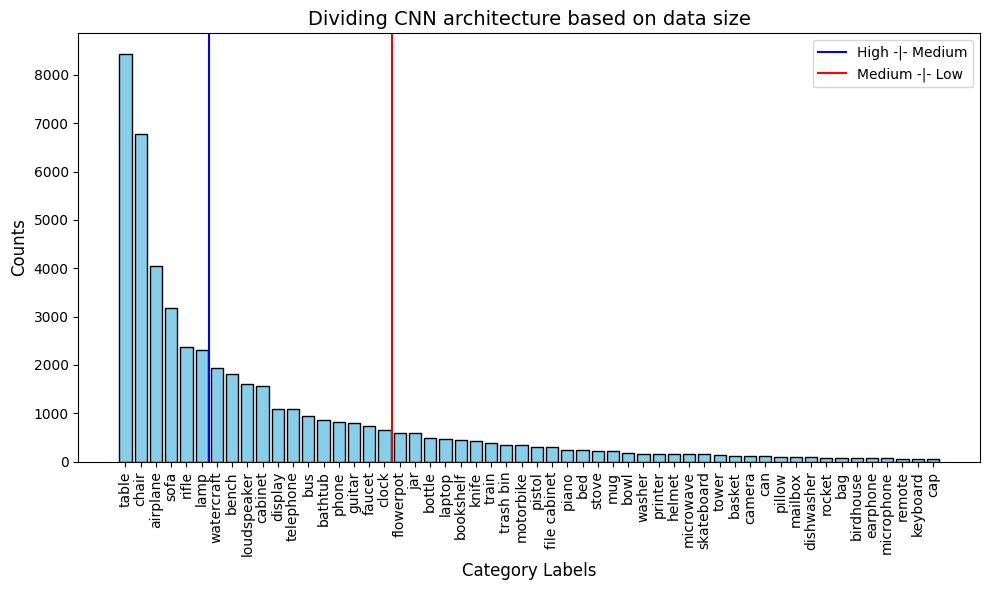

In [137]:
plt.figure(figsize=(10, 6))
plot_barplot(category_counts, title="Dividing CNN architecture based on data size", xlabel="Category Labels", ylabel="Counts", ascending=False)
plt.axvline(x=5.5, color='b', label='High -|- Medium')
plt.axvline(x=17.5, color='r', label='Medium -|- Low')
plt.legend()
plt.show()

We have divided our data into __3 subsets__, so we need to come up with __3 different CNN architectures__.

For __high-complex CNNs__ we will use the __base model__ that we already tested previously.

Let's build a __function to train all categories__ on a given section.

In [7]:
# sorting categories based on instances amount
sorted_categories = sorted(category_counts.items(), key=lambda x:x[1], reverse=True)
sorted_categories[:10]

[('table', 8436),
 ('chair', 6778),
 ('airplane', 4045),
 ('sofa', 3173),
 ('rifle', 2373),
 ('lamp', 2318),
 ('watercraft', 1939),
 ('bench', 1813),
 ('loudspeaker', 1597),
 ('cabinet', 1571)]

In [11]:
# Separate only categories with large amount of data
high_categories = sorted_categories[:6]
high_categories

[('table', 8436),
 ('chair', 6778),
 ('airplane', 4045),
 ('sofa', 3173),
 ('rifle', 2373),
 ('lamp', 2318)]

In [19]:
import pickle

# write list into binary file
def write_list(category_id, list_):
    with open(f'metrics/{category_id}', 'wb') as f:
        pickle.dump(list_, f)

# read list from binary file into memory
def read_list(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

list_example=[1,2,3]
print("Saving list as a binary file.")
write_list('list_example', list_example)
print("Reading list from binary file:")
read_list('metrics/list_example')

Saving list as a binary file.
Reading list from binary file:


[1, 2, 3]

In [2]:
def final_cnn_training_and_performance(category_label, category_labels, test_size, val_size):
    # set the category id
    category_id = list(category_labels.keys())[list(category_labels.values()).index(category_label)]
    print(f"Processing category: '{category_label}': {category_id}")

    # split the data
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(category_id,
                                                                input_shape=(128, 128, 1),
                                                                output_shape=(32, 32, 32, 1),
                                                                images_per_voxel=1,
                                                                test_size=test_size,
                                                                validation_size=val_size)
    # print split details
    print(f"Used {100*test_size}% for test subset and {100*val_size}% for validation set.")
    print(f"X train shape: {x_train.shape}")
    print(f"X test shape: {x_test.shape}")
    print(f"X validation shape: {x_val.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Y validation shape: {y_val.shape}")
    
    # train the model
    model, model_history = train_model_one_category(category_id,
                                                    x_train,
                                                    x_test,
                                                    y_train,
                                                    y_test,
                                                    input_shape=(128, 128, 1),
                                                    output_shape=(32, 32, 32, 1),
                                                    epochs=20,
                                                    batch_size=32)
    # plot model performance over epochs
    plot_model_performance(model_history = model_history,
                           title=f"Category '{category_label}': Model Performance",
                           filename=f'plots/performance/{category_label}.png')
    
    # validate model, calculate metrics
    metrics = validate_model(model, x_val, y_val, run_on='G', model_name=category_label)
    
    # predict voxels on unseen data
    y_pred = model.predict(x_val)
    
    # calculate iou metric and plot
    ious, avg = calculate_iou_batch(y_pred, y_val, get_values=True)
    plot_iou_metrics(ious, avg, category_label)
    
    # save all metrics as a file
    metrics += [avg]
    write_list(category_id, metrics)

Processing category: 'table': 04379243
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (5609, 128, 128, 1)
X test shape: (2405, 128, 128, 1)
X validation shape: (422, 128, 128, 1)
Y train shape: (5609, 32, 32, 32, 1)
Y test shape: (2405, 32, 32, 32, 1)
Y validation shape: (422, 32, 32, 32, 1)
Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.8039 - binary_crossentropy: 0.6826
Epoch 1: val_loss improved from -inf to 0.47360, saving model to models/128x32\04379243.keras
176/176 [==============================] - 106s 577ms/step - loss: 0.6826 - accuracy: 0.8039 - binary_crossentropy: 0.6826 - val_loss: 0.4736 - val_accuracy: 0.8187 - val_binary_crossentropy: 0.4736
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8398 - binary_crossentropy: 0.4165
Epoch 2: val_loss did not improve from 0.47360
176/176 [==============================] - 51s 291ms/step - loss: 0.4165 - accuracy: 0.8398

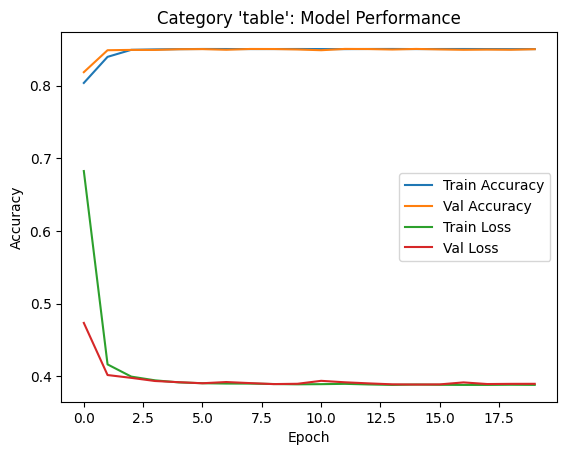

Evaluating model on category: table.
14/14 [==============================] - 1s 51ms/step


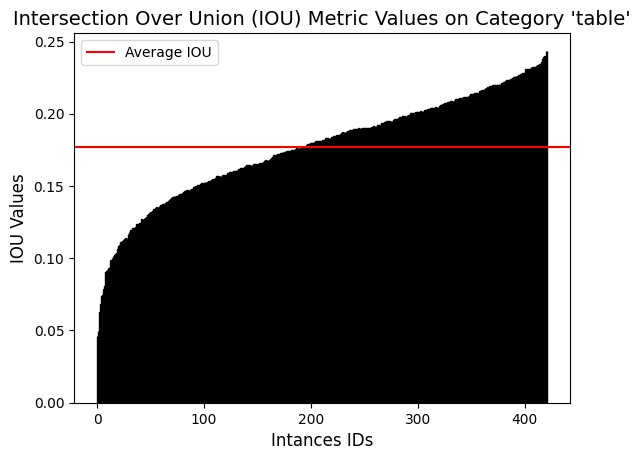

In [3]:
# Train 'table' category on high-capacity CNN
final_cnn_training_and_performance(category_label='table',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'chair': 03001627
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (4507, 128, 128, 1)
X test shape: (1932, 128, 128, 1)
X validation shape: (339, 128, 128, 1)
Y train shape: (4507, 32, 32, 32, 1)
Y test shape: (1932, 32, 32, 32, 1)
Y validation shape: (339, 32, 32, 32, 1)
Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8338 - binary_crossentropy: 0.3929
Epoch 1: val_loss improved from -inf to 0.34358, saving model to models/128x32\03001627.keras
141/141 [==============================] - 110s 746ms/step - loss: 0.3929 - accuracy: 0.8338 - binary_crossentropy: 0.3929 - val_loss: 0.3436 - val_accuracy: 0.8454 - val_binary_crossentropy: 0.3436
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8458 - binary_crossentropy: 0.3318
Epoch 2: val_loss did not improve from 0.34358
141/141 [==============================] - 42s 294ms/step - loss: 0.3318 - accuracy: 0.8458

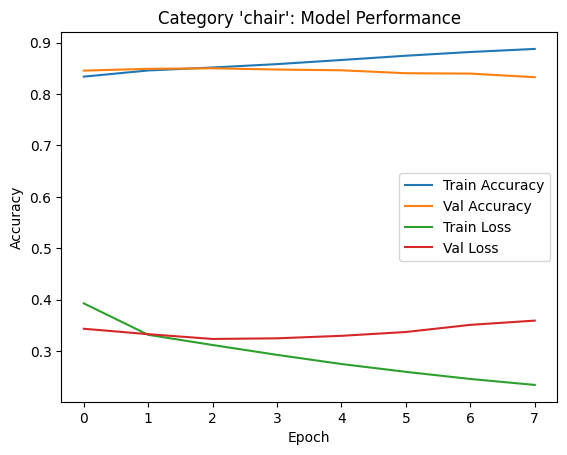

Evaluating model on category: chair.
11/11 [==============================] - 1s 50ms/step


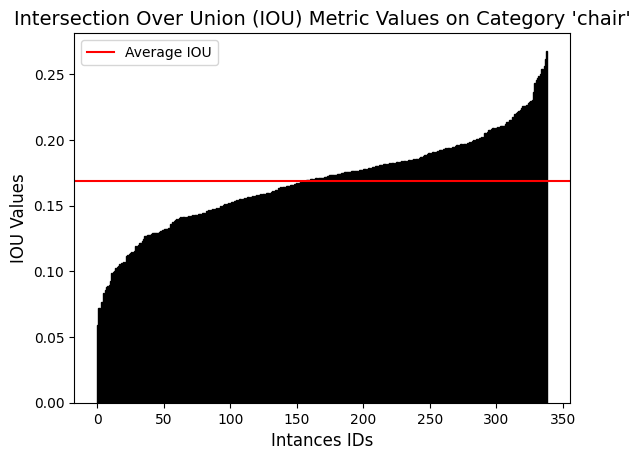

In [2]:
# Train 'chair' category on high-capacity CNN
final_cnn_training_and_performance(category_label='chair',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'airplane': 02691156
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (2689, 128, 128, 1)
X test shape: (1153, 128, 128, 1)
X validation shape: (203, 128, 128, 1)
Y train shape: (2689, 32, 32, 32, 1)
Y test shape: (1153, 32, 32, 32, 1)
Y validation shape: (203, 32, 32, 32, 1)
Epoch 1/20
85/85 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9058 - binary_crossentropy: 0.2091
Epoch 1: val_loss improved from -inf to 0.16711, saving model to models/128x32\02691156.keras
85/85 [==============================] - 73s 807ms/step - loss: 0.2091 - accuracy: 0.9058 - binary_crossentropy: 0.2091 - val_loss: 0.1671 - val_accuracy: 0.9143 - val_binary_crossentropy: 0.1671
Epoch 2/20
85/85 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9179 - binary_crossentropy: 0.1639
Epoch 2: val_loss did not improve from 0.16711
85/85 [==============================] - 26s 302ms/step - loss: 0.1639 - accuracy: 0.9179 - bin

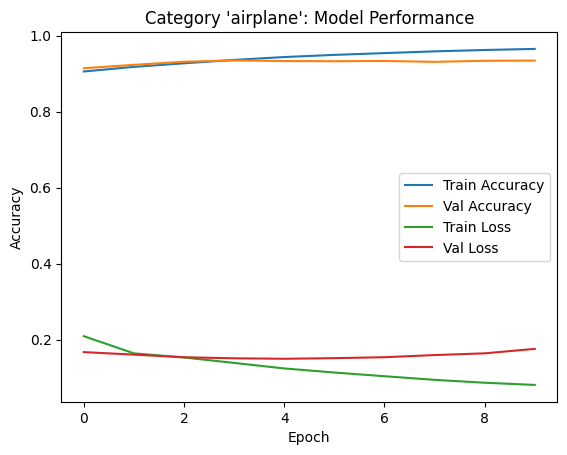

Evaluating model on category: airplane.
7/7 [==============================] - 0s 50ms/step


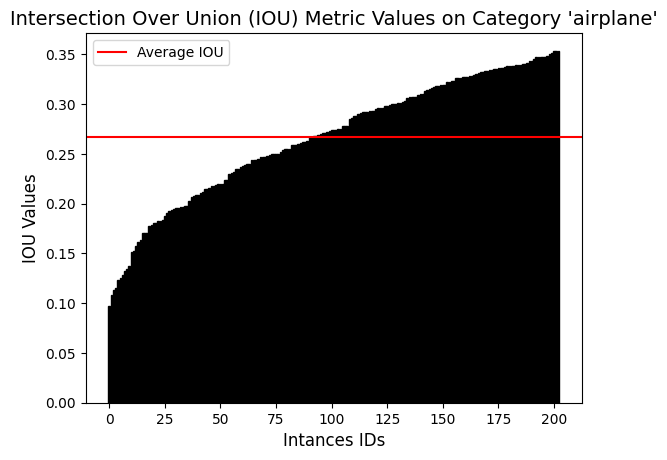

In [2]:
# Train 'airplane' category on high-capacity CNN
final_cnn_training_and_performance(category_label='airplane',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'sofa': 04256520
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (2109, 128, 128, 1)
X test shape: (905, 128, 128, 1)
X validation shape: (159, 128, 128, 1)
Y train shape: (2109, 32, 32, 32, 1)
Y test shape: (905, 32, 32, 32, 1)
Y validation shape: (159, 32, 32, 32, 1)
Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.6914 - binary_crossentropy: 0.5803
Epoch 1: val_loss improved from -inf to 0.53426, saving model to models/128x32\04256520.keras
66/66 [==============================] - 71s 997ms/step - loss: 0.5803 - accuracy: 0.6914 - binary_crossentropy: 0.5803 - val_loss: 0.5343 - val_accuracy: 0.7125 - val_binary_crossentropy: 0.5343
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7181 - binary_crossentropy: 0.5203
Epoch 2: val_loss did not improve from 0.53426
66/66 [==============================] - 20s 306ms/step - loss: 0.5203 - accuracy: 0.7181 - binary_cr

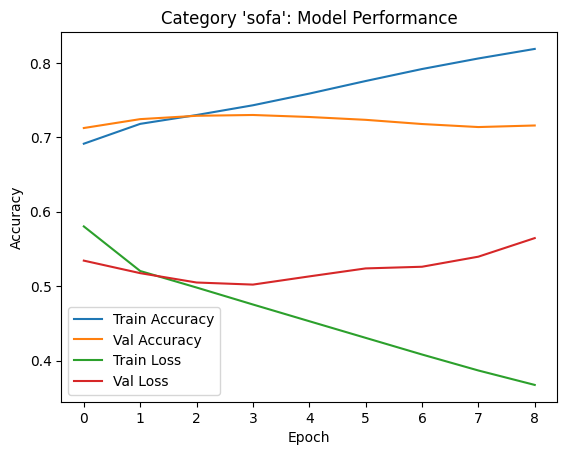

Evaluating model on category: sofa.
5/5 [==============================] - 0s 49ms/step


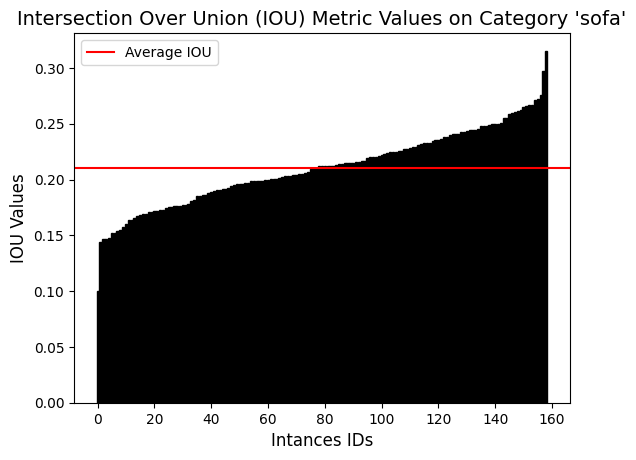

In [2]:
# Train 'sofa' category on high-capacity CNN
final_cnn_training_and_performance(category_label='sofa',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'rifle': 04090263
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (1577, 128, 128, 1)
X test shape: (677, 128, 128, 1)
X validation shape: (119, 128, 128, 1)
Y train shape: (1577, 32, 32, 32, 1)
Y test shape: (677, 32, 32, 32, 1)
Y validation shape: (119, 32, 32, 32, 1)
Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7343 - binary_crossentropy: 0.5185
Epoch 1: val_loss improved from -inf to 0.45923, saving model to models/128x32\04090263.keras
50/50 [==============================] - 106s 2s/step - loss: 0.5185 - accuracy: 0.7343 - binary_crossentropy: 0.5185 - val_loss: 0.4592 - val_accuracy: 0.7493 - val_binary_crossentropy: 0.4592
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.7566 - binary_crossentropy: 0.4430
Epoch 2: val_loss did not improve from 0.45923
50/50 [==============================] - 16s 322ms/step - loss: 0.4430 - accuracy: 0.7566 - binary_cro

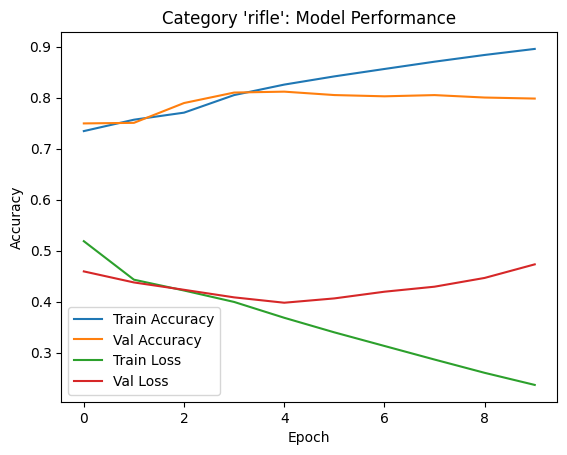

Evaluating model on category: rifle.
4/4 [==============================] - 0s 50ms/step


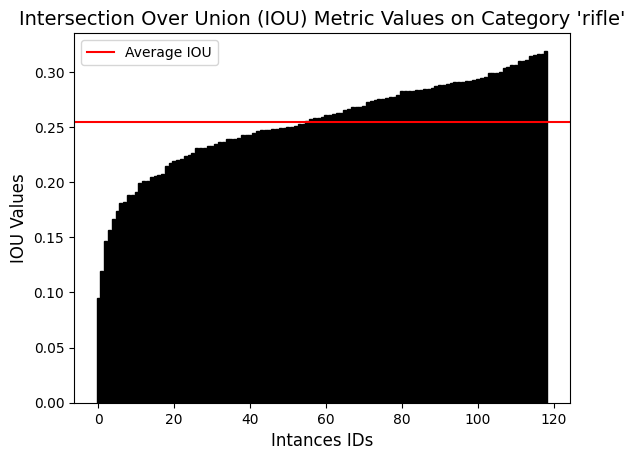

In [2]:
# Train 'rifle' category on high-capacity CNN
final_cnn_training_and_performance(category_label='rifle',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'lamp': 03636649
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (1541, 128, 128, 1)
X test shape: (661, 128, 128, 1)
X validation shape: (116, 128, 128, 1)
Y train shape: (1541, 32, 32, 32, 1)
Y test shape: (661, 32, 32, 32, 1)
Y validation shape: (116, 32, 32, 32, 1)
Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.8270 - binary_crossentropy: 0.7989
Epoch 1: val_loss improved from -inf to 0.64030, saving model to models/128x32\03636649.keras
49/49 [==============================] - 66s 1s/step - loss: 0.7989 - accuracy: 0.8270 - binary_crossentropy: 0.7989 - val_loss: 0.6403 - val_accuracy: 0.8687 - val_binary_crossentropy: 0.6403
Epoch 2/20
49/49 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.8676 - binary_crossentropy: 0.5782
Epoch 2: val_loss did not improve from 0.64030
49/49 [==============================] - 17s 340ms/step - loss: 0.5782 - accuracy: 0.8676 - binary_cross

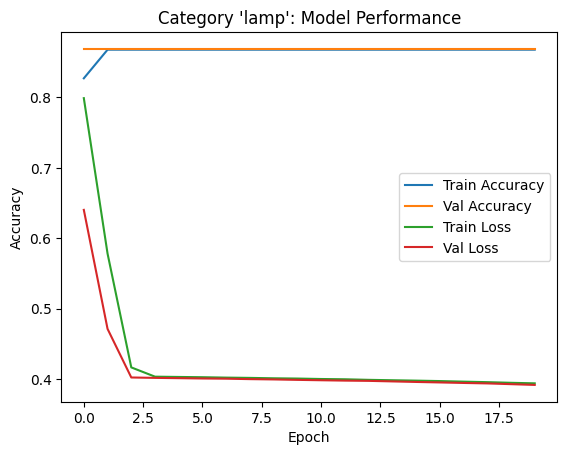

Evaluating model on category: lamp.
4/4 [==============================] - 0s 51ms/step


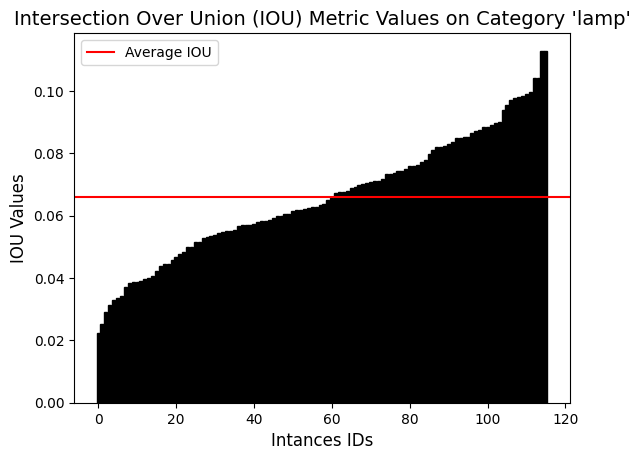

In [2]:
# Train 'lamp' category on high-capacity CNN
final_cnn_training_and_performance(category_label='lamp',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Now that we have __trained high-capacity models__ for the categories with large amounts of data, 

we can __validate their performance__ by __calculating and visualizing metrics__.

## Part VIb. Validating the Model and Metrics: IoU, Accuracy, Loss, Visual Comparisons (High-capacity models) <a class="anchor" id="#part-6b"></a>

Fortunately, during training we __saved the metrics into__ lists into __binary files__ on our hard-drive disk.

Now we can retreive those lists and __plot the metrics of CNN performance__.

These metrics are:
- __validation accuracies__
- __validation binary crossentropies__
- intersection over union __(IOU) averages__ from the validation subset data

In [90]:
high_labels = [x[0] for x in high_categories]
high_ids = [list(category_labels.keys())[list(category_labels.values()).index(label)] for label in high_labels]
print(f"High category labels: {high_labels}")
print(f"High category IDs: {high_ids}")

High category labels: ['table', 'chair', 'airplane', 'sofa', 'rifle', 'lamp']
High category IDs: ['04379243', '03001627', '02691156', '04256520', '04090263', '03636649']


In [91]:
metrics_categories = [read_list(f'metrics/{category_id}') for category_id in high_ids]
print(f"Read metrics from {len(metrics_categories)} categories.")
print(f"Metrics from category '{high_labels[0]}':")
metrics_categories[0]

Read metrics from 6 categories.
Metrics from category 'table':


[0.38710904121398926,
 0.8512195944786072,
 0.38710904121398926,
 0.17682704000960128]

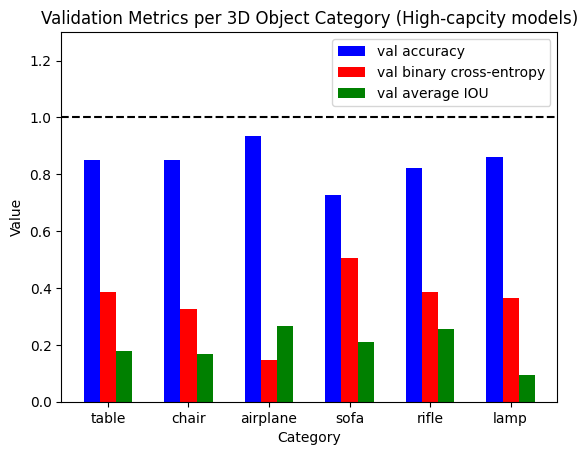

In [92]:
def plot_metrics_categories(metrics_categories, labels, title):
    binary_entropies = [metrics[0] for metrics in metrics_categories]
    accuracies = [metrics[1] for metrics in metrics_categories]
    average_ious = [metrics[3] for metrics in metrics_categories]
    x = np.arange(len(labels))
    bar_width = 0.2
    
    ax = plt.gca()
    ax.set_ylim([0, 1.3])
    plt.axhline(y=1.0, color='black', linestyle = '--')
    
    plt.bar(x - bar_width, accuracies, bar_width, color='b', label='val accuracy')
    plt.bar(x, binary_entropies, bar_width, color='r', label='val binary cross-entropy')
    plt.bar(x + bar_width, average_ious, bar_width, color='g', label='val average IOU')
    plt.xticks(x, labels) 
    
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Value")
    plt.legend()

plot_metrics_categories(metrics_categories, high_labels, "Validation Metrics per 3D Object Category (High-capcity models)")
plt.show()

From the plot we get the following __insights__:
- the __'airplane'__ category shows the __best acccuracy but lowest binary cross-entropy and average IOU__ from all categories; this could indicate __overfitting__
- the __'sofa'__ category shows the __most stable metrics (less difference between them)__ across all categories
- the __'lamp'__ category shows a __high accuracy and very low IOU average__, indicating and __overfitted model__
- overall, all categories have shown __significant performance__

Let's continue with categories with low amounts of data.

## Part VIIa. Developing the CNN architecture, Training and testing (Low-capacity models) <a class="anchor" id="#part-7a"></a>

For these categories we have to use __less complex models, with a low capacity__.

Engineering another __CNN architecture__ with these requirements will __prevent overfitting__ when training our models with such less data.

Let's apply multiple __techniques to reduce complexity__:
- __Node droputs__
- __Regularization__

In [4]:
# Separate only categories with low amount of data
low_categories = sorted_categories[6:18]
low_categories

[('watercraft', 1939),
 ('bench', 1813),
 ('loudspeaker', 1597),
 ('cabinet', 1571),
 ('display', 1093),
 ('telephone', 1089),
 ('bus', 939),
 ('bathtub', 856),
 ('phone', 831),
 ('guitar', 797),
 ('faucet', 744),
 ('clock', 651)]

In [2]:
from keras.layers import Flatten, Dense, Dropout, Reshape, GlobalAveragePooling2D
from keras.regularizers import l2

def build_cnn_model(input_shape, output_shape):
    # Define the model
    model = Sequential()
    
    # 2D convolutional layers (feature extraction from images)
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     kernel_regularizer=l2(1e-4), input_shape=input_shape))  # Reduced to 16 filters
    model.add(Dropout(0.2))  # 20% dropout
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=l2(1e-4)))  # Downsample to 64x64
    
    # Global average pooling instead of Flatten
    model.add(GlobalAveragePooling2D())
    
    # Dense layers for mapping to 3D structure
    model.add(Dense(32 * 32 * 32, activation='relu', kernel_regularizer=l2(1e-4)))  # Keep 3D output size
    model.add(Dropout(0.3))
    model.add(Reshape((32, 32, 32, 1)))  # Keep original output shape
    
    # 3D convolutional layers (minimal decoder)
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))  # Reduced filters to 8
    model.add(Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Output layer remains

    return model
    
# Summary of the model
with tf.device('/CPU:0'):
    build_cnn_model(input_shape=(128, 128, 1),
                    output_shape=(32, 32, 32, 1)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                        

For this new __low capacity CNN architecture__ we have performed:

- __Node dropouts:__ we __drop 20%__ of the nodes __twice__ during the 2D convolutional layers, and __30%__ of the nodes __once__ during the 3D covolutional layers.

This reduces the parameters of our models, generalizing the learning process.

- __L2 Regularization:__ By adding an L2 penalty to the loss function, the model is encouraged to __keep the weights small__,

which generally leads to simpler and more __generalizable models__.

Let's train our remaining classes with this low-capacity CNN.

Processing category: 'watercraft': 04530566
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (1289, 128, 128, 1)
X test shape: (553, 128, 128, 1)
X validation shape: (97, 128, 128, 1)
Y train shape: (1289, 32, 32, 32, 1)
Y test shape: (553, 32, 32, 32, 1)
Y validation shape: (97, 32, 32, 32, 1)
Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7024 - binary_crossentropy: 0.5738
Epoch 1: val_loss improved from -inf to 0.53968, saving model to models/128x32\04530566.keras
41/41 [==============================] - 4s 64ms/step - loss: 0.5819 - accuracy: 0.7024 - binary_crossentropy: 0.5738 - val_loss: 0.5397 - val_accuracy: 0.7211 - val_binary_crossentropy: 0.5323
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.7222 - binary_crossentropy: 0.5222
Epoch 2: val_loss did not improve from 0.53968
41/41 [==============================] - 2s 50ms/step - loss: 0.5296 - accuracy: 0.7222 - binary_cr

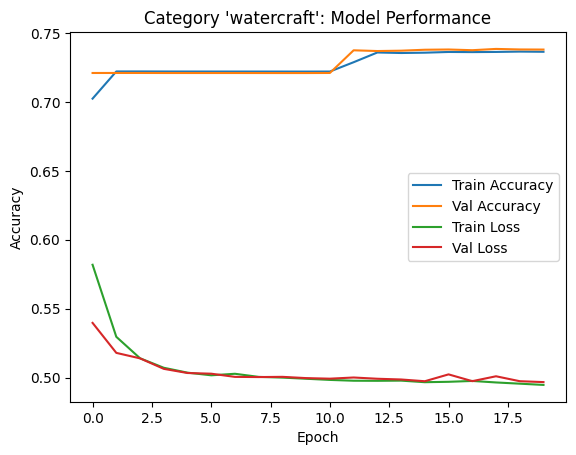

Evaluating model on category: watercraft.
4/4 [==============================] - 0s 9ms/step


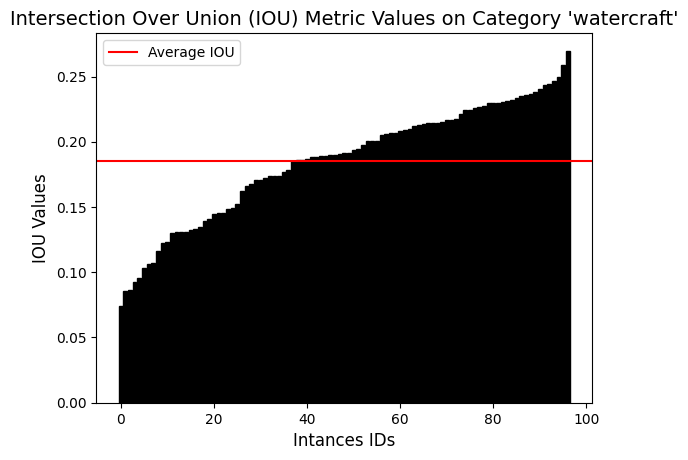

In [18]:
# Train 'watercraft' category on high-capacity CNN
final_cnn_training_and_performance(category_label='watercraft',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'bench': 02828884
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (1205, 128, 128, 1)
X test shape: (517, 128, 128, 1)
X validation shape: (91, 128, 128, 1)
Y train shape: (1205, 32, 32, 32, 1)
Y test shape: (517, 32, 32, 32, 1)
Y validation shape: (91, 32, 32, 32, 1)
Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7761 - binary_crossentropy: 0.5848
Epoch 1: val_loss improved from -inf to 0.47584, saving model to models/128x32\02828884.keras
38/38 [==============================] - 4s 66ms/step - loss: 0.5926 - accuracy: 0.7761 - binary_crossentropy: 0.5848 - val_loss: 0.4758 - val_accuracy: 0.8063 - val_binary_crossentropy: 0.4677
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.8076 - binary_crossentropy: 0.4606
Epoch 2: val_loss did not improve from 0.47584
38/38 [==============================] - 2s 51ms/step - loss: 0.4686 - accuracy: 0.8076 - binary_crossen

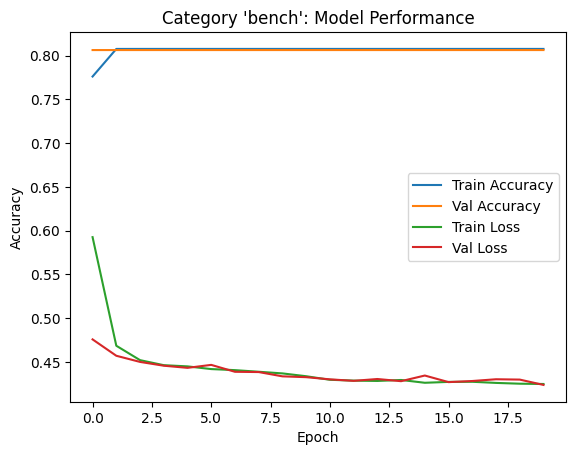

Evaluating model on category: bench.
3/3 [==============================] - 0s 10ms/step


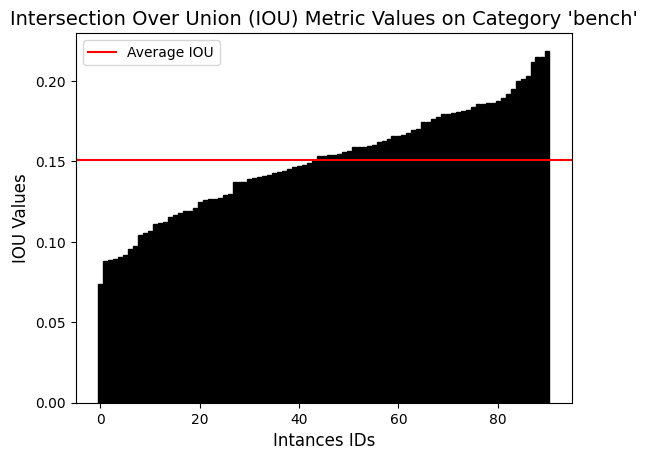

In [19]:
# Train 'bench' category on high-capacity CNN
final_cnn_training_and_performance(category_label='bench',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'loudspeaker': 03691459
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (1061, 128, 128, 1)
X test shape: (456, 128, 128, 1)
X validation shape: (80, 128, 128, 1)
Y train shape: (1061, 32, 32, 32, 1)
Y test shape: (456, 32, 32, 32, 1)
Y validation shape: (80, 32, 32, 32, 1)
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.6608 - binary_crossentropy: 0.6479
Epoch 1: val_loss improved from -inf to 0.60899, saving model to models/128x32\03691459.keras
34/34 [==============================] - 3s 63ms/step - loss: 0.6556 - accuracy: 0.6608 - binary_crossentropy: 0.6479 - val_loss: 0.6090 - val_accuracy: 0.6888 - val_binary_crossentropy: 0.6028
Epoch 2/20
33/34 [============================>.] - ETA: 0s - loss: 0.6069 - accuracy: 0.6840 - binary_crossentropy: 0.6012
Epoch 2: val_loss did not improve from 0.60899
34/34 [==============================] - 2s 49ms/step - loss: 0.6067 - accuracy: 0.6838 - binary_c

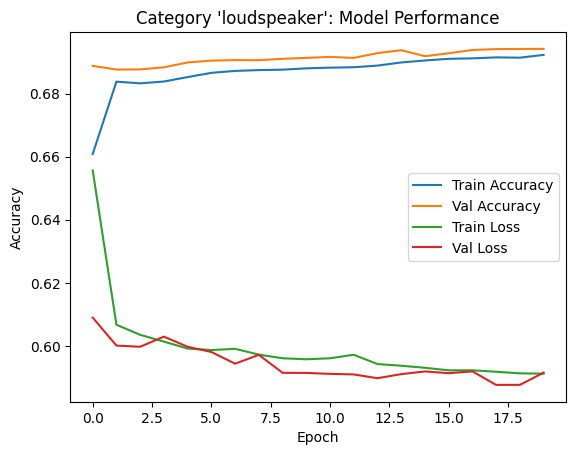

Evaluating model on category: loudspeaker.
3/3 [==============================] - 0s 9ms/step


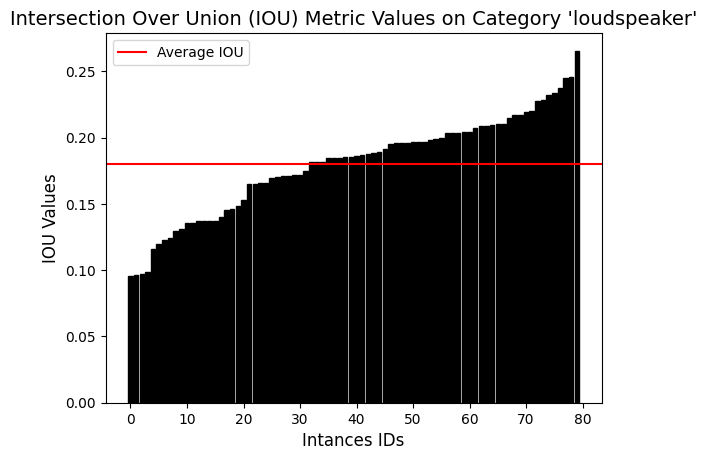

In [20]:
# Train 'loudspeaker' category on high-capacity CNN
final_cnn_training_and_performance(category_label='loudspeaker',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'cabinet': 02933112
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (1044, 128, 128, 1)
X test shape: (448, 128, 128, 1)
X validation shape: (79, 128, 128, 1)
Y train shape: (1044, 32, 32, 32, 1)
Y test shape: (448, 32, 32, 32, 1)
Y validation shape: (79, 32, 32, 32, 1)
Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.6397 - binary_crossentropy: 0.6811
Epoch 1: val_loss improved from -inf to 0.66323, saving model to models/128x32\02933112.keras
33/33 [==============================] - 3s 75ms/step - loss: 0.6888 - accuracy: 0.6397 - binary_crossentropy: 0.6811 - val_loss: 0.6632 - val_accuracy: 0.6864 - val_binary_crossentropy: 0.6576
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.6806 - binary_crossentropy: 0.6445
Epoch 2: val_loss did not improve from 0.66323
33/33 [==============================] - 2s 50ms/step - loss: 0.6495 - accuracy: 0.6806 - binary_cross

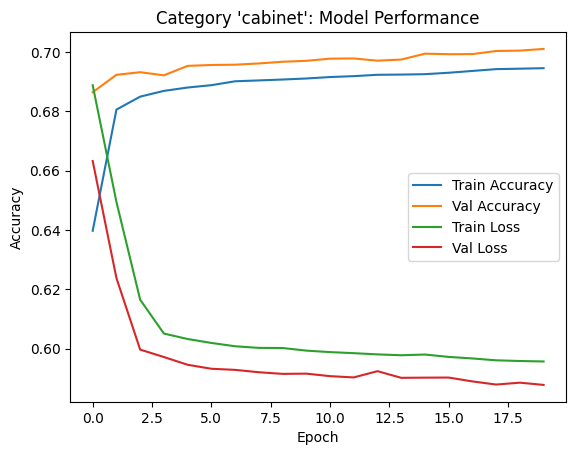

Evaluating model on category: cabinet.
3/3 [==============================] - 0s 9ms/step


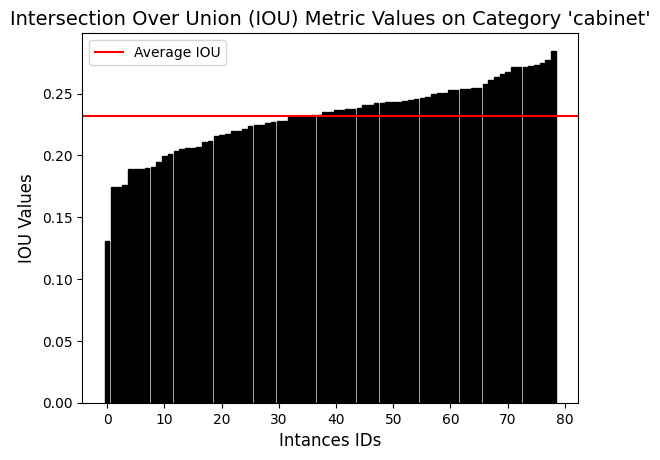

In [21]:
# Train 'cabinet' category on high-capacity CNN
final_cnn_training_and_performance(category_label='cabinet',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'display': 03211117
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (726, 128, 128, 1)
X test shape: (312, 128, 128, 1)
X validation shape: (55, 128, 128, 1)
Y train shape: (726, 32, 32, 32, 1)
Y test shape: (312, 32, 32, 32, 1)
Y validation shape: (55, 32, 32, 32, 1)
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6811 - binary_crossentropy: 0.6221
Epoch 1: val_loss improved from -inf to 0.59372, saving model to models/128x32\03211117.keras
23/23 [==============================] - 3s 97ms/step - loss: 0.6312 - accuracy: 0.6811 - binary_crossentropy: 0.6221 - val_loss: 0.5937 - val_accuracy: 0.7159 - val_binary_crossentropy: 0.5858
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7121 - binary_crossentropy: 0.5842
Epoch 2: val_loss did not improve from 0.59372
23/23 [==============================] - 1s 51ms/step - loss: 0.5919 - accuracy: 0.7121 - binary_crossen

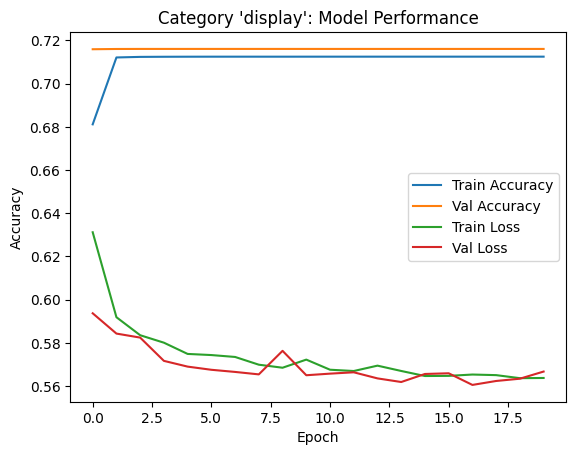

Evaluating model on category: display.
2/2 [==============================] - 0s 8ms/step


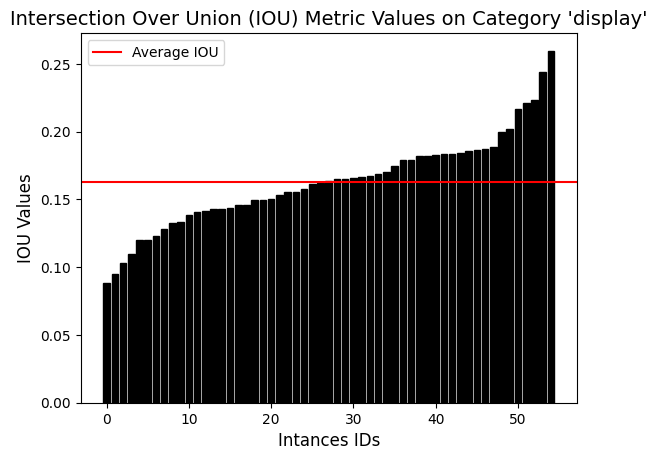

In [22]:
# Train 'display' category on high-capacity CNN
final_cnn_training_and_performance(category_label='display',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'bus': 02924116
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (624, 128, 128, 1)
X test shape: (268, 128, 128, 1)
X validation shape: (47, 128, 128, 1)
Y train shape: (624, 32, 32, 32, 1)
Y test shape: (268, 32, 32, 32, 1)
Y validation shape: (47, 32, 32, 32, 1)
Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.5811 - binary_crossentropy: 0.6694
Epoch 1: val_loss improved from -inf to 0.63481, saving model to models/128x32\02924116.keras
20/20 [==============================] - 3s 89ms/step - loss: 0.6778 - accuracy: 0.5811 - binary_crossentropy: 0.6694 - val_loss: 0.6348 - val_accuracy: 0.6089 - val_binary_crossentropy: 0.6285
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.6044 - binary_crossentropy: 0.6222
Epoch 2: val_loss did not improve from 0.63481
20/20 [==============================] - 1s 51ms/step - loss: 0.6283 - accuracy: 0.6038 - binary_crossentrop

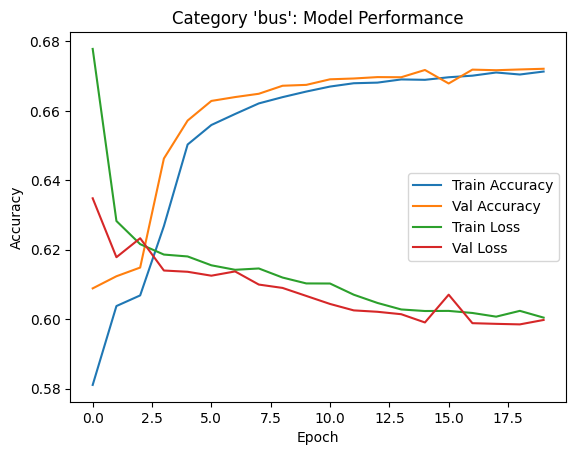

Evaluating model on category: bus.
2/2 [==============================] - 0s 9ms/step


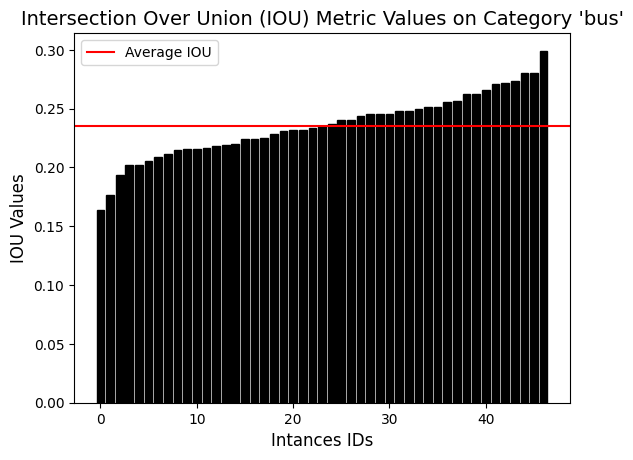

In [23]:
# Train 'bus' category on high-capacity CNN
final_cnn_training_and_performance(category_label='bus',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'bathtub': 02808440
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (569, 128, 128, 1)
X test shape: (244, 128, 128, 1)
X validation shape: (43, 128, 128, 1)
Y train shape: (569, 32, 32, 32, 1)
Y test shape: (244, 32, 32, 32, 1)
Y validation shape: (43, 32, 32, 32, 1)
Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6903 - binary_crossentropy: 0.6076
Epoch 1: val_loss improved from -inf to 0.58220, saving model to models/128x32\02808440.keras
18/18 [==============================] - 3s 96ms/step - loss: 0.6172 - accuracy: 0.6903 - binary_crossentropy: 0.6076 - val_loss: 0.5822 - val_accuracy: 0.7193 - val_binary_crossentropy: 0.5743
Epoch 2/20
17/18 [===========================>..] - ETA: 0s - loss: 0.5729 - accuracy: 0.7254 - binary_crossentropy: 0.5652
Epoch 2: val_loss did not improve from 0.58220
18/18 [==============================] - 1s 51ms/step - loss: 0.5737 - accuracy: 0.7248 - binary_crossen

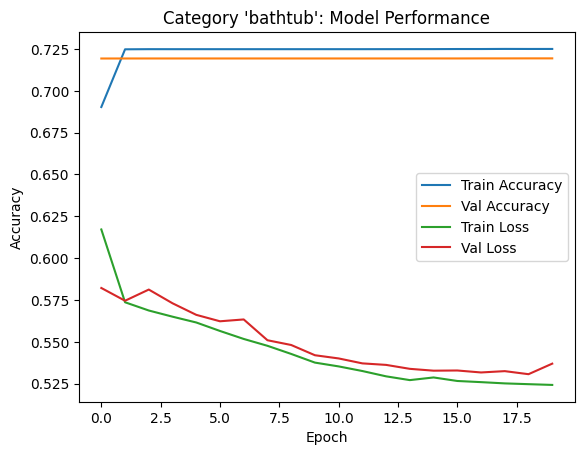

Evaluating model on category: bathtub.
2/2 [==============================] - 0s 10ms/step


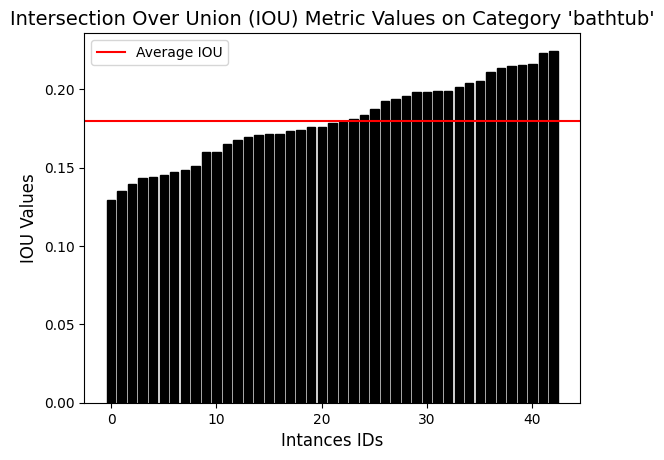

In [25]:
# Train 'bathtub' category on high-capacity CNN
final_cnn_training_and_performance(category_label='bathtub',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'phone': 02992529
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (552, 128, 128, 1)
X test shape: (237, 128, 128, 1)
X validation shape: (42, 128, 128, 1)
Y train shape: (552, 32, 32, 32, 1)
Y test shape: (237, 32, 32, 32, 1)
Y validation shape: (42, 32, 32, 32, 1)
Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5536 - binary_crossentropy: 0.6670
Epoch 1: val_loss improved from -inf to 0.65959, saving model to models/128x32\02992529.keras
18/18 [==============================] - 2s 86ms/step - loss: 0.6762 - accuracy: 0.5536 - binary_crossentropy: 0.6670 - val_loss: 0.6596 - val_accuracy: 0.5597 - val_binary_crossentropy: 0.6527
Epoch 2/20
17/18 [===========================>..] - ETA: 0s - loss: 0.6594 - accuracy: 0.6204 - binary_crossentropy: 0.6529
Epoch 2: val_loss improved from 0.65959 to 0.66330, saving model to models/128x32\02992529.keras
18/18 [==============================] - 1s 64ms/step - 

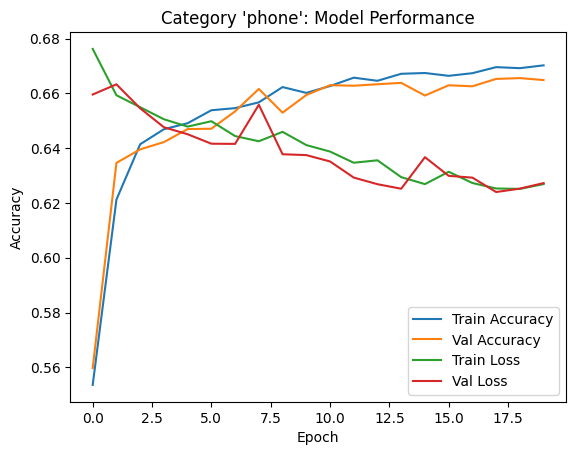

Evaluating model on category: phone.
2/2 [==============================] - 0s 9ms/step


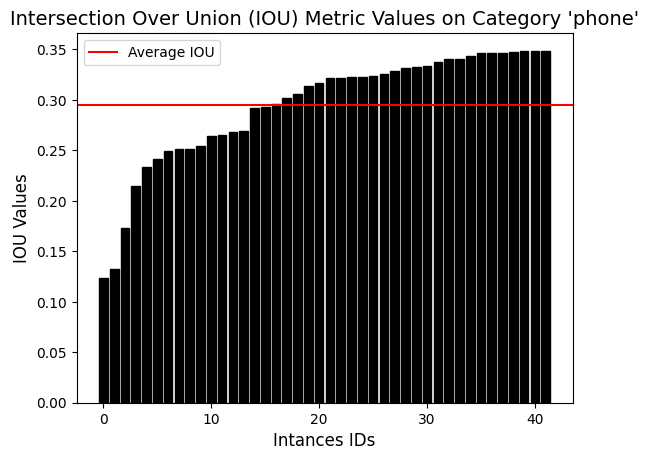

In [26]:
# Train 'phone' category on high-capacity CNN
final_cnn_training_and_performance(category_label='phone',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'guitar': 03467517
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (529, 128, 128, 1)
X test shape: (228, 128, 128, 1)
X validation shape: (40, 128, 128, 1)
Y train shape: (529, 32, 32, 32, 1)
Y test shape: (228, 32, 32, 32, 1)
Y validation shape: (40, 32, 32, 32, 1)
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6905 - binary_crossentropy: 0.6174
Epoch 1: val_loss improved from -inf to 0.47995, saving model to models/128x32\03467517.keras
17/17 [==============================] - 3s 105ms/step - loss: 0.6273 - accuracy: 0.6905 - binary_crossentropy: 0.6174 - val_loss: 0.4799 - val_accuracy: 0.7300 - val_binary_crossentropy: 0.4690
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7258 - binary_crossentropy: 0.4591
Epoch 2: val_loss did not improve from 0.47995
17/17 [==============================] - 1s 53ms/step - loss: 0.4712 - accuracy: 0.7258 - binary_crossen

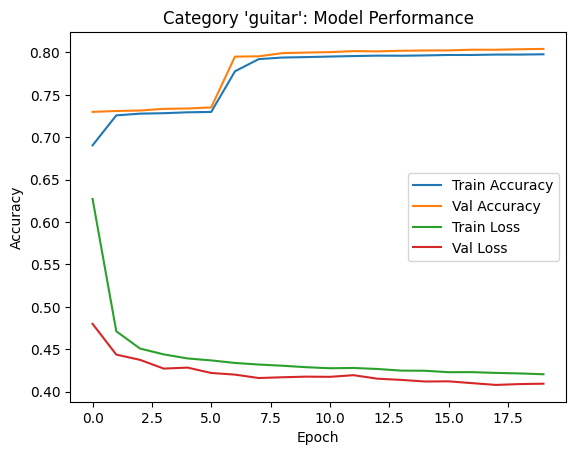

Evaluating model on category: guitar.
2/2 [==============================] - 0s 9ms/step


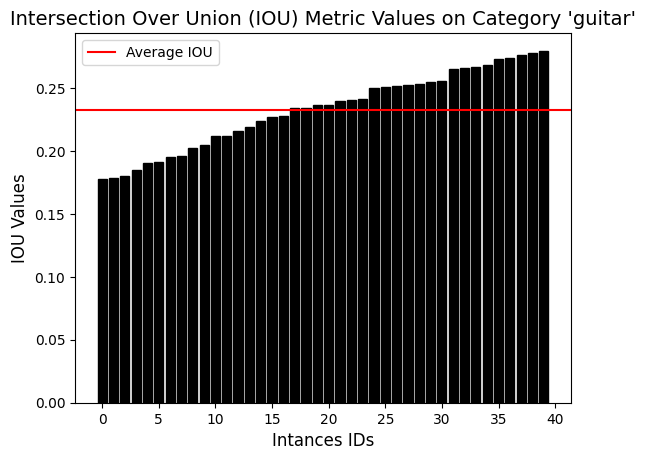

In [27]:
# Train 'guitar' category on high-capacity CNN
final_cnn_training_and_performance(category_label='guitar',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'faucet': 03325088
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (494, 128, 128, 1)
X test shape: (212, 128, 128, 1)
X validation shape: (38, 128, 128, 1)
Y train shape: (494, 32, 32, 32, 1)
Y test shape: (212, 32, 32, 32, 1)
Y validation shape: (38, 32, 32, 32, 1)
Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.7639 - binary_crossentropy: 0.6917
Epoch 1: val_loss improved from -inf to 0.69069, saving model to models/128x32\03325088.keras
16/16 [==============================] - 2s 98ms/step - loss: 0.7011 - accuracy: 0.7639 - binary_crossentropy: 0.6917 - val_loss: 0.6907 - val_accuracy: 0.8955 - val_binary_crossentropy: 0.6838
Epoch 2/20
15/16 [===========================>..] - ETA: 0s - loss: 0.6832 - accuracy: 0.8925 - binary_crossentropy: 0.6772
Epoch 2: val_loss did not improve from 0.69069
16/16 [==============================] - 1s 51ms/step - loss: 0.6829 - accuracy: 0.8931 - binary_crossent

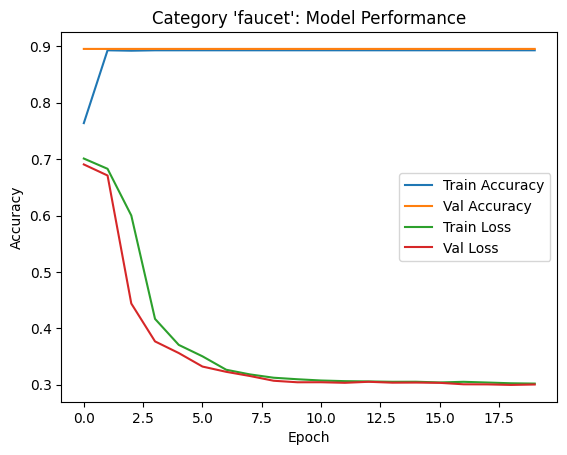

Evaluating model on category: faucet.
2/2 [==============================] - 0s 11ms/step


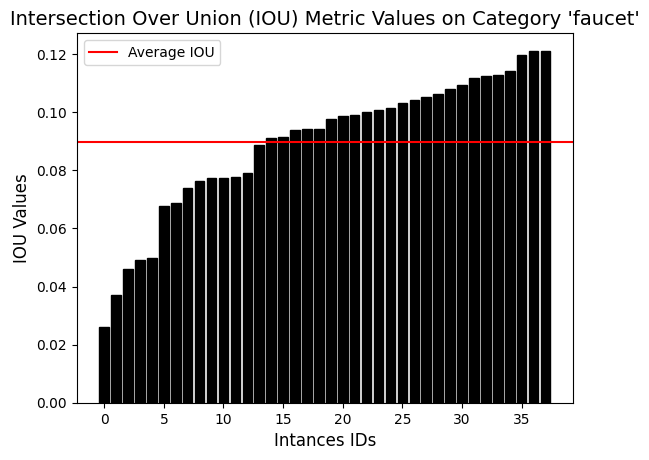

In [28]:
# Train 'faucet' category on high-capacity CNN
final_cnn_training_and_performance(category_label='faucet',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Processing category: 'clock': 03046257
Used 30.0% for test subset and 5.0% for validation set.
X train shape: (432, 128, 128, 1)
X test shape: (186, 128, 128, 1)
X validation shape: (33, 128, 128, 1)
Y train shape: (432, 32, 32, 32, 1)
Y test shape: (186, 32, 32, 32, 1)
Y validation shape: (33, 32, 32, 32, 1)
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.5999 - binary_crossentropy: 0.6660
Epoch 1: val_loss improved from -inf to 0.65580, saving model to models/128x32\03046257.keras
14/14 [==============================] - 2s 99ms/step - loss: 0.6759 - accuracy: 0.5999 - binary_crossentropy: 0.6660 - val_loss: 0.6558 - val_accuracy: 0.6274 - val_binary_crossentropy: 0.6478
Epoch 2/20
13/14 [==========================>...] - ETA: 0s - loss: 0.6561 - accuracy: 0.6204 - binary_crossentropy: 0.6485
Epoch 2: val_loss did not improve from 0.65580
14/14 [==============================] - 1s 52ms/step - loss: 0.6567 - accuracy: 0.6186 - binary_crossentr

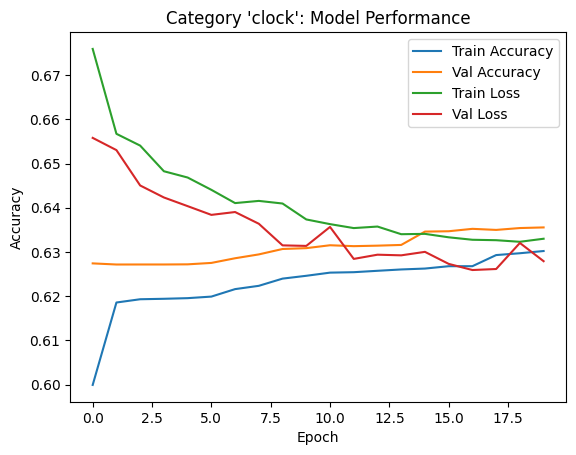

Evaluating model on category: clock.
2/2 [==============================] - 0s 9ms/step


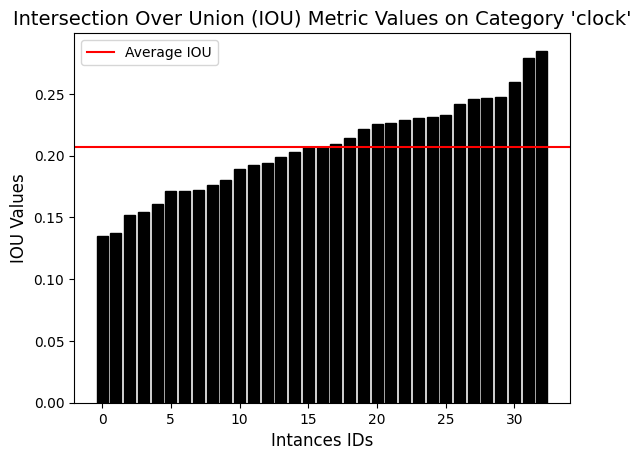

In [29]:
# Train 'clock' category on high-capacity CNN
final_cnn_training_and_performance(category_label='clock',
                                   category_labels=category_labels,
                                   test_size=0.3,
                                   val_size=0.05)

Now that we have __trained 11 (eleven) new low-capacity models__ on these low data subsets,

we have __visualized the performance on each epoch and IOUs__ of each of these models.

Let's actually __validate and compare these models metrics__ from each other.

## Part VIIb. Validating the Model and Metrics: IoU, Accuracy, Loss, Visual Comparisons (Low-capacity models) <a class="anchor" id="#part-7b"></a>

To validate these models and __compare metrics__ from each other we need to plot a __multi-bar plot__.

Let's re-utilize the previous implemented functions, but using the __new metrics__ as parameters.

In [94]:
low_labels = [x[0] for x in low_categories]
low_ids = [list(category_labels.keys())[list(category_labels.values()).index(label)] for label in low_labels]
del low_labels[5]
del low_ids[5]
print(f"Low category labels: {low_labels}")
print(f"Low category IDs: {low_ids}")

Low category labels: ['watercraft', 'bench', 'loudspeaker', 'cabinet', 'display', 'bus', 'bathtub', 'phone', 'guitar', 'faucet', 'clock']
Low category IDs: ['04530566', '02828884', '03691459', '02933112', '03211117', '02924116', '02808440', '02992529', '03467517', '03325088', '03046257']


In [95]:
metrics_categories = [read_list(f'metrics/{category_id}') for category_id in low_ids]
print(f"Read metrics from {len(metrics_categories)} categories.")
print(f"Metrics from category '{low_labels[0]}':")
metrics_categories[0]

Read metrics from 11 categories.
Metrics from category 'watercraft':


[0.4667221009731293, 0.755126953125, 0.4620206654071808, 0.1854487509930475]

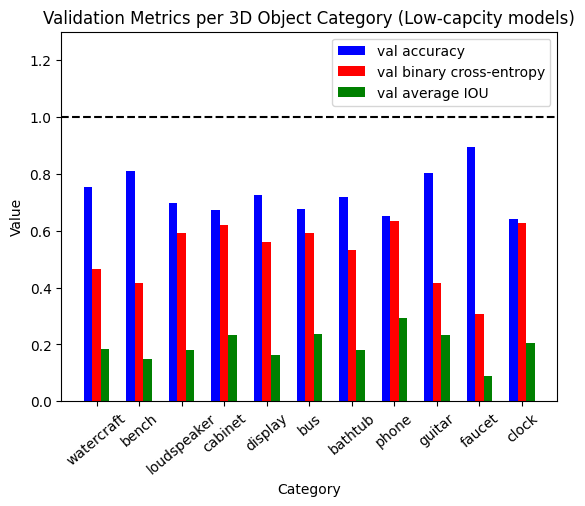

In [103]:
plot_metrics_categories(metrics_categories, low_labels, "Validation Metrics per 3D Object Category (Low-capcity models)")
plt.xticks(rotation=40)
plt.show()

__Insights__ from the plot:
- For these __low-capacity models__ we are visualizing __significant increase in the validation loss__ (binary cross entropy) of our models


- Validation __accuracies have reduced collectively__ compared to our previous high-capacity models as well.

    This is a __result of our dropout and regularization techniques to reduce complexity__.

- Overall __IOUs averages have slightly increased__ as well, due to our models __ability to generalize__ better.

    Now, between __4 or 5 models have an IOU greater than 0.2__

## Part VIII. Training, testing, and validation a Final model using all available data <a class="anchor" id="#part-8"></a>

To finalize our experimentation we will __train a single model with ALL of our data.__

This model will utilize our initial __high-capacity model with 570 million parameters__.

As we will deal with lots of data, we will __not utilize techniques to reduce complexity__ for now.

But first, let's list all categories (and #instances) that we haven't trained yet due to not having sufficient data.

These categories, along with the previous ones will be used to trained a new model.

In [9]:
print(f"Remaining untrained categories: {len(sorted_categories[18:])}")
sorted_categories[18:]

Remaining untrained categories: 36


[('flowerpot', 602),
 ('jar', 596),
 ('bottle', 498),
 ('laptop', 460),
 ('bookshelf', 452),
 ('knife', 424),
 ('train', 389),
 ('trash bin', 343),
 ('motorbike', 337),
 ('pistol', 307),
 ('file cabinet', 298),
 ('piano', 239),
 ('bed', 233),
 ('stove', 218),
 ('mug', 214),
 ('bowl', 186),
 ('washer', 169),
 ('printer', 166),
 ('helmet', 162),
 ('microwave', 152),
 ('skateboard', 152),
 ('tower', 133),
 ('basket', 113),
 ('camera', 113),
 ('can', 108),
 ('pillow', 96),
 ('mailbox', 94),
 ('dishwasher', 93),
 ('rocket', 85),
 ('bag', 83),
 ('birdhouse', 73),
 ('earphone', 73),
 ('microphone', 67),
 ('remote', 66),
 ('keyboard', 65),
 ('cap', 56)]

In [11]:
print(f"All categories to train last model: {len(sorted_categories)}")
print(f"Total of {sum([x[1] for x in sorted_categories])} instances.")
sorted_categories

All categories to train last model: 54
Total of 48958 instances.


[('table', 8436),
 ('chair', 6778),
 ('airplane', 4045),
 ('sofa', 3173),
 ('rifle', 2373),
 ('lamp', 2318),
 ('watercraft', 1939),
 ('bench', 1813),
 ('loudspeaker', 1597),
 ('cabinet', 1571),
 ('display', 1093),
 ('telephone', 1089),
 ('bus', 939),
 ('bathtub', 856),
 ('phone', 831),
 ('guitar', 797),
 ('faucet', 744),
 ('clock', 651),
 ('flowerpot', 602),
 ('jar', 596),
 ('bottle', 498),
 ('laptop', 460),
 ('bookshelf', 452),
 ('knife', 424),
 ('train', 389),
 ('trash bin', 343),
 ('motorbike', 337),
 ('pistol', 307),
 ('file cabinet', 298),
 ('piano', 239),
 ('bed', 233),
 ('stove', 218),
 ('mug', 214),
 ('bowl', 186),
 ('washer', 169),
 ('printer', 166),
 ('helmet', 162),
 ('microwave', 152),
 ('skateboard', 152),
 ('tower', 133),
 ('basket', 113),
 ('camera', 113),
 ('can', 108),
 ('pillow', 96),
 ('mailbox', 94),
 ('dishwasher', 93),
 ('rocket', 85),
 ('bag', 83),
 ('birdhouse', 73),
 ('earphone', 73),
 ('microphone', 67),
 ('remote', 66),
 ('keyboard', 65),
 ('cap', 56)]

In [2]:
def split_data_stacked(category_ids, input_shape, output_shape, images_per_voxel, test_size, validation_size):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Load the numpy arrays (input and output)
    images_files, voxels_files = [], []
    for category_id in category_ids:
        i_files = np.load(f'images/{input_reso}/{category_id}_images.npy')
        v_files = np.load(f'voxels/{output_reso}/{category_id}_voxels.npy')
        if i_files.shape[0]//10 != v_files.shape[0]:
            continue
        images_files.append(i_files)
        voxels_files.append(v_files)
    images = np.concatenate(images_files, axis=0)
    del images_files
    voxels = np.concatenate(voxels_files, axis=0)
    del voxels_files

    # Prepare data based on required images per 3D object
    images, voxels = prepare_data_based_on_images_per_voxel(images, voxels, images_per_voxel)

    # Split into test and train subsets
    x, x_val, y, y_val = train_test_split(images, voxels, test_size=validation_size)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    return x_train, x_test, x_val, y_train, y_test, y_val

category_ids = [category_ids_dict[cat[0]] for cat in sorted_categories]
x_train, x_test, x_val, y_train, y_test, y_val = split_data_stacked(category_ids,
                                                                input_shape=(128, 128, 1),
                                                                output_shape=(32, 32, 32, 1),
                                                                images_per_voxel=1,
                                                                test_size=0.3,
                                                                validation_size=0.05)

print(f"Used 30.0% for test subset and 5%% for validation set.")
print(f"X train shape: {x_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"X validation shape: {x_val.shape}")
print(f"Y train shape: {y_train.shape}")
print(f"Y test shape: {y_test.shape}")
print(f"Y validation shape: {y_val.shape}")

Used 30.0% for test subset and 5%% for validation set.
X train shape: (31384, 128, 128, 1)
X test shape: (13451, 128, 128, 1)
X validation shape: (2360, 128, 128, 1)
Y train shape: (31384, 32, 32, 32, 1)
Y test shape: (13451, 32, 32, 32, 1)
Y validation shape: (2360, 32, 32, 32, 1)


In [2]:
def stacked_data_cnn_training_and_performance(x_train, x_test, x_val, y_train, y_test, y_val, test_size, val_size):
    print(f"Processing data from all categories.")
    
    # train the model
    model, model_history = train_model_one_category('all_categories',
                                                    x_train,
                                                    x_test,
                                                    y_train,
                                                    y_test,
                                                    input_shape=(128, 128, 1),
                                                    output_shape=(32, 32, 32, 1),
                                                    epochs=20,
                                                    batch_size=32)
    # plot model performance over epochs
    plot_model_performance(model_history = model_history,
                           title=f"Training All Categories at once': Model Performance",
                           filename=f'plots/performance/all.png')
    
    # validate model, calculate metrics
    metrics = validate_model(model, x_val, y_val, run_on='G', model_name='All Categories')
    
    # predict voxels on unseen data
    y_pred = model.predict(x_val)
    
    # calculate iou metric and plot
    ious, avg = calculate_iou_batch(y_pred, y_val, get_values=True)
    plot_iou_metrics(ious, avg, 'All Categories')
    
    # save all metrics as a file
    metrics += [avg]
    write_list('all', metrics)

with tf.device('/CPU:0'):
    stacked_data_cnn_training_and_performance(x_train, x_test, x_val, y_train, y_test, y_val, 0.3, 0.05)

Processing data from all categories.
Epoch 1/20
981/981 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.7918 - binary_crossentropy: 0.4371
Epoch 1: val_loss improved from -inf to 0.40858, saving model to models/128x32\all_categories.keras
981/981 [==============================] - 7713s 8s/step - loss: 0.4371 - accuracy: 0.7918 - binary_crossentropy: 0.4371 - val_loss: 0.4086 - val_accuracy: 0.8041 - val_binary_crossentropy: 0.4086
Epoch 2/20
353/981 [=========>....................] - ETA: 1:22:53 - loss: 0.3928 - accuracy: 0.8103 - binary_crossentropy: 0.3928


KeyboardInterrupt



In [1]:
# importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import trimesh
import glob
import os

def get_category_names(data_path):

    # Initialize an empty array and loop through the folders within data path
    category_names = []
    for folder in os.scandir(data_path):

        # if the folder name starts with a number then it's a category name
        folder_basename = os.path.basename(folder.path)
        if folder.is_dir() and folder_basename[0].isdigit():
            category_names.append(folder_basename)
    return category_names

# Get all the available categories (types of 3D objects)
categories = get_category_names(r"D:\_Projects\ShapeNetCore")

# Set a dictionary to map category identifiers into actual labels
category_labels = {
    "04379243": "table", "03593526": "jar", "04225987": "skateboard", "02958343": "car",
    "02876657": "bottle", "04460130": "tower", "03001627": "chair", "02871439": "bookshelf",
    "02942699": "camera", "02691156": "airplane", "03642806": "laptop", "02801938": "basket",
    "04256520": "sofa", "03624134": "knife", "02946921": "can", "04090263": "rifle",
    "04468005": "train", "03938244": "pillow", "03636649": "lamp", "02747177": "trash bin",
    "03710193": "mailbox", "04530566": "watercraft", "03790512": "motorbike", "03207941": "dishwasher",
    "02828884": "bench", "03948459": "pistol", "04099429": "rocket", "03691459": "loudspeaker",
    "03337140": "file cabinet", "02773838": "bag", "02933112": "cabinet", "02818832": "bed",
    "02843684": "birdhouse", "03211117": "display", "03928116": "piano", "03261776": "earphone",
    "04401088": "telephone", "04330267": "stove", "03759954": "microphone", "02924116": "bus",
    "03797390": "mug", "04074963": "remote", "02808440": "bathtub", "02880940": "bowl",
    "03085013": "keyboard", "03467517": "guitar", "04554684": "washer", "02834778": "bicycle",
    "03325088": "faucet", "04004475": "printer", "02954340": "cap", "02992529":"phone",
    "03046257": "clock", "03513137" : "helmet", "03761084" : "microwave", "03991062" : "flowerpot"
}

def prepare_data_based_on_images_per_voxel(images_npy, voxels_npy, images_per_voxel):

    if images_per_voxel < 1 or images_per_voxel > 10:
        raise Exception("images_per_voxel should be a positive integer <= 10")

    # Data augmentation on the 3D voxels data if required (due to more image data)
    if images_per_voxel != 1:
        voxels_npy = np.repeat(voxels_npy, repeats=images_per_voxel, axis=0)

    if images_per_voxel == 10:
        return images_npy, voxels_npy
    
    # Data segmentation on the images data if required (due to less voxel data)
    chunk_size = 10
    num_chunks = images_npy.shape[0] // chunk_size
    
    # Initialize empty list of selected images
    selected_images = []
    
    # Loop over each chunk and get start and end of current chunk
    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        
        # Get the indices for equally spaced elements within this chunk, appending the result
        indices = np.linspace(chunk_start, chunk_end - 1, images_per_voxel, dtype=int)
        selected_images.append(images_npy[indices])
    
    # Convert the result list to a NumPy
    images_npy = np.concatenate(selected_images, axis=0)
    
    return images_npy, voxels_npy

from sklearn.model_selection import train_test_split

def split_data(category, input_shape, output_shape, images_per_voxel, test_size, validation_size, perc_data_used=1):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Load the numpy arrays (input and output)
    images = np.load(f'images/{input_reso}/{category}_images.npy')
    voxels = np.load(f'voxels/{output_reso}/{category}_voxels.npy')

    # Prepare data based on required images per 3D object
    images, voxels = prepare_data_based_on_images_per_voxel(images, voxels, images_per_voxel)

    # Split into test and train subsets
    x, x_val, y, y_val = train_test_split(images, voxels, test_size=validation_size)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

    # Optionally work with only a percentage of the data for test & train, but include all data (100%) by default
    if perc_data_used != 1:
        l_train, l_test = len(x_train), len(x_test)
        s_train, s_test = int(l_train * perc_data_used), int(l_test * perc_data_used)
        x_train, x_test, y_train, y_test = x_train[:s_train], x_test[:s_test], y_train[:s_train], y_test[:s_test]
    
    return x_train, x_test, x_val, y_train, y_test, y_val

from keras.backend import clear_session
import gc
import pickle

def clear_ram():
    clear_session()
    gc.collect()

def save_dictionary_as_pickle(initial_path, filename, dictionary):
    # Save dictionary
    with open(initial_path + filename, 'wb+') as f:
        pickle.dump(dictionary, f)

from keras.models import Sequential
from keras.layers import Conv2D, Conv3D, Dense, Flatten, Reshape, Conv2DTranspose

def build_cnn_model(input_shape, output_shape):    
    # Define the model
    model = Sequential()
    
    # 2D convolutional layers (feature extraction from images)
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=2, padding='same'))  # Downsample to 64x64
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(32 * 32 * 32, activation='relu'))  # Fully connected layer for 3D mapping
    
    # Reshape to 3D
    model.add(Reshape(output_shape))
    
    # 3D convolutional layers
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Output layer
    return model

from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model_one_category(category,
                             x_train, x_test, y_train, y_test,
                             input_shape,
                             output_shape,
                             epochs,
                             batch_size,
                             use_es=True, # should the model use early stopping
                             use_mc=True): # should the model save checkpoints
    
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Instantiate and compile the model
    model = build_cnn_model(input_shape, output_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])        
    
    # Early Stopping
    es = EarlyStopping(monitor='val_loss',
                       mode='min',
                       verbose=1,
                       patience=5,
                       restore_best_weights=True)

    # Model Checkpoint
    mc = ModelCheckpoint(filepath=f'models/{input_reso}x{output_reso}/{category}.keras',
                         monitor='val_loss',
                         mode='max',
                         verbose=1,
                         save_best_only=True,
                         )

    # Set the callbacks
    callbacks = []
    if use_es: callbacks.append(es)
    if use_mc: callbacks.append(mc)

    # Train Model based on given parameters
    model_history = model.fit(x_train,
                              y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(x_test, y_test),
                              verbose=1,
                              callbacks=callbacks)
    return model, model_history


import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_performance(model_history, title, filename):
    
    # Plot the model history
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])

    # Set the labels, title, and legend, and save the picture
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])
    plt.savefig(filename)
    plt.show()

from keras.models import load_model

def load_model_from_file(input_shape, output_shape, images_per_voxel, category):
    
    # Load the model of the category, saved as keras file
    return load_model(f'models/{images_per_voxel}x{input_shape[0]}x{output_shape[0]}/{category}.keras')


def validate_model(model, x_val, y_val, run_on, model_name):        
    # Run on CPU or GPU depending on param
    with tf.device(f'/{run_on}PU:0'):
    
        # Set strings with the input and output reso for file reading
        print(f'Evaluating model on category: {model_name}.')
        
        # Evaluate model with test data
        metrics = model.evaluate(x_val, y_val)

    return metrics

def calculate_iou(voxel_1, voxel_2):
    # calculate the IOU metric on 2 given voxels as numpy arrays
    overlap = voxel_1 * voxel_2
    union = voxel_1 + voxel_2
    return overlap.sum() / float(union.sum())

def calculate_iou_batch(voxels_batch_1, voxels_batch_2, get_values=False):
    # calculate the average of IOU metrics from each pair of voxels from 2 batches
    num_instances = voxels_batch_1.shape[0]
    ious = []
    sum_iou = 0
    for i in range(num_instances):
        iou = calculate_iou(voxels_batch_1[i], voxels_batch_2[i])
        sum_iou += iou
        ious.append(iou)

    # return a list with all IOUs if required, otherwise return average
    if get_values:
        return ious, sum_iou / num_instances
    return sum_iou / num_instances

# function to plot calculated IOU metrics including the average
def plot_iou_metrics(ious, avg, category_label):
    plt.bar([i for i in range(len(ious))], sorted(ious), color='black', edgecolor='black')
    plt.axhline(y = avg, color = 'r', linestyle = '-', label="Average IOU") 
    plt.legend()
    plt.title(f"Intersection Over Union (IOU) Metric Values on Category '{category_label}'", fontsize=14)
    plt.xlabel('Intances IDs', fontsize=12)
    plt.ylabel('IOU Values', fontsize=12)
    plt.show()

import pickle

# write list into binary file
def write_list(category_id, list_):
    with open(f'metrics/{category_id}', 'wb') as f:
        pickle.dump(list_, f)

def final_cnn_training_and_performance(category_label, category_labels, test_size, val_size):
    # set the category id
    category_id = list(category_labels.keys())[list(category_labels.values()).index(category_label)]
    print(f"Processing category: '{category_label}': {category_id}")

    # split the data
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(category_id,
                                                                input_shape=(128, 128, 1),
                                                                output_shape=(32, 32, 32, 1),
                                                                images_per_voxel=1,
                                                                test_size=test_size,
                                                                validation_size=val_size)
    # print split details
    print(f"Used {100*test_size}% for test subset and {100*val_size}% for validation set.")
    print(f"X train shape: {x_train.shape}")
    print(f"X test shape: {x_test.shape}")
    print(f"X validation shape: {x_val.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Y validation shape: {y_val.shape}")
    
    # train the model
    model, model_history = train_model_one_category(category_id,
                                                    x_train,
                                                    x_test,
                                                    y_train,
                                                    y_test,
                                                    input_shape=(128, 128, 1),
                                                    output_shape=(32, 32, 32, 1),
                                                    epochs=20,
                                                    batch_size=32)
    # plot model performance over epochs
    plot_model_performance(model_history = model_history,
                           title=f"Category '{category_label}': Model Performance",
                           filename=f'plots/performance/{category_label}.png')
    
    # validate model, calculate metrics
    metrics = validate_model(model, x_val, y_val, run_on='G', model_name=category_label)
    
    # predict voxels on unseen data
    y_pred = model.predict(x_val)
    
    # calculate iou metric and plot
    ious, avg = calculate_iou_batch(y_pred, y_val, get_values=True)
    plot_iou_metrics(ious, avg, category_label)
    
    # save all metrics as a file
    metrics += [avg]
    write_list(category_id, metrics)


# Set a dictionary to map category identifiers into actual labels
category_labels = {
    "04379243": "table", "03593526": "jar", "04225987": "skateboard", "02958343": "car",
    "02876657": "bottle", "04460130": "tower", "03001627": "chair", "02871439": "bookshelf",
    "02942699": "camera", "02691156": "airplane", "03642806": "laptop", "02801938": "basket",
    "04256520": "sofa", "03624134": "knife", "02946921": "can", "04090263": "rifle",
    "04468005": "train", "03938244": "pillow", "03636649": "lamp", "02747177": "trash bin",
    "03710193": "mailbox", "04530566": "watercraft", "03790512": "motorbike", "03207941": "dishwasher",
    "02828884": "bench", "03948459": "pistol", "04099429": "rocket", "03691459": "loudspeaker",
    "03337140": "file cabinet", "02773838": "bag", "02933112": "cabinet", "02818832": "bed",
    "02843684": "birdhouse", "03211117": "display", "03928116": "piano", "03261776": "earphone",
    "04401088": "telephone", "04330267": "stove", "03759954": "microphone", "02924116": "bus",
    "03797390": "mug", "04074963": "remote", "02808440": "bathtub", "02880940": "bowl",
    "03085013": "keyboard", "03467517": "guitar", "04554684": "washer", "02834778": "bicycle",
    "03325088": "faucet", "04004475": "printer", "02954340": "cap", "02992529":"phone",
    "03046257": "clock", "03513137" : "helmet", "03761084" : "microwave", "03991062" : "flowerpot"
}

category_ids_dict = {value: key for key, value in category_labels.items()}

def get_obj_files(data_path, recursive=True):
    
    # Retrieve OBJ files from the data path
    obj_files = [file for file in glob.glob(data_path + r"\**\*.obj", recursive=recursive)]
    print(f"Found {len(obj_files)} OBJ files.")
    return obj_files

# Save the paths of each of the OBJ files into a list
DATA_PATH = r"D:\_Projects\ShapeNetCore"
obj_files = get_obj_files(DATA_PATH)

# function to count the data instances (3D objects) per each category
def count_categories(obj_files, categories, category_labels):
    category_counts = {}

    # Loop through the OBJ files
    for obj_file in obj_files:

        # Loop through each category
        for category in categories:

            # If the OBJ file belongs to the category, then add the instance and continue to the next file
            if category in obj_file:
                label = category_labels[category]
                category_counts[label] = category_counts.get(label, 0) + 1
                break
    return category_counts

category_counts = count_categories(obj_files, categories, category_labels)

# sorting categories based on instances amount
sorted_categories = sorted(category_counts.items(), key=lambda x:x[1], reverse=True)

Found 48958 OBJ files.


# ==========================================================================
# ==========================================================================
# ==========================================================================

In [15]:
def save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename='images'):
    
    # Loop through the PNG files and initialize an empty array that will contain np arrays
    print("Starting pipeline...")
    np_arrays = []
    curr_progress, prev_progress = 0.0, -0.5
    for i, png_file in enumerate(png_files):

        # Open the image and convert into grayscale
        img = Image.open(png_file)
        img_gray = img.convert("L")
        
        # Resize the image to the desired shape and into a numpy array
        img_resized = img_gray.resize(image_shape)
        img_array = np.array(img_resized)
        
        # Reshape the array to (image shape, 1)
        new_shape = tuple(list(image_shape) + [1])
        img_array = img_array.reshape(new_shape)
        np_arrays.append(img_array)
        
        # Print progress, but not on every loop
        curr_progress = round(100 * (i+1) / len(png_files), 2)
        if (curr_progress - prev_progress) >= 0.5:
            prev_progress = float(curr_progress)
            print(f"{curr_progress}%", end=" ")
            if curr_progress != 0.0 and curr_progress % 10.0 == 0:
                print(f"({i+1} files done)")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"\nFinal NumPy array shape: {np_arrays_stacked.shape}")
    
    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

In [19]:
# Convert a single testing image into NPY
save_npy_array_from_png(['test1.png'], (128, 128), npy_filename='test_image1')

Starting pipeline...
100.0% (1 files done)

Final NumPy array shape: (1, 128, 128, 1)


In [20]:
# Load the image and reshape adding a batch dimension for prediction
image_npy = np.load('test_image1.npy')
print(image_npy.shape)
image_npy = image_npy.reshape(1, 128, 128, 1)

# Make a Prediction and remove batch channel from prediction
#test_model_2 = tf.keras.models.load_model('models/1x128x32/02691156.keras')
predicted_voxel = model.predict(image_npy)
predicted_voxel = predicted_voxel[0, :, :, :, 0]

# Convert the voxel grid to a binary format (can modify threshold)
predicted_voxel_binary = (predicted_voxel > 0.5).astype(bool)
print(predicted_voxel_binary.shape)

save_voxel_grid_to_obj(predicted_voxel_binary, "test_voxel1.obj")

(1, 128, 128, 1)
1/1 [==============================] - 0s 22ms/step
(32, 32, 32)


In [28]:
predicted_voxel_all.shape

(203, 32, 32, 32, 1)

In [22]:
print(x_val.shape)
predicted_voxel_all = model.predict(x_val, batch_size=1)
predicted_voxel = predicted_voxel_all[1, :, :, :, 0]

# Convert the voxel grid to a binary format (can modify threshold)
predicted_voxel_binary = (predicted_voxel > 0.5).astype(bool)
print(predicted_voxel_binary.shape)

save_voxel_grid_to_obj(predicted_voxel_binary, "test_voxel6.obj")

(203, 128, 128, 1)
203/203 [==============================] - 3s 13ms/step
(32, 32, 32)


In [66]:
image_npy = np.load('voxels/32/02691156_voxels.npy') # test_image.npy')
image_npy = image_npy[1]
print(image_npy.shape)
image_npy = image_npy[:, :, :, 0]
print(image_npy.shape)
save_voxel_grid_to_obj(image_npy, "test_voxel.obj")

(32, 32, 32, 1)
(32, 32, 32)


In [81]:
images_npy = np.load('images/128/02691156_images.npy') # test_image.npy
image_npy = images_npy[1800:1801, :, :, :]
image_npy_to_png = images_npy[1800, :, :, 0]
npy_to_png(image_npy_to_png, 'npy_image.png')

predicted_voxel = test_model.predict(image_npy)
predicted_voxel = predicted_voxel[0, :, :, :, 0]

# Convert the voxel grid to a binary format (can modify threshold)
predicted_voxel_binary = (predicted_voxel > 0.5).astype(bool)
print(predicted_voxel_binary.shape)

save_voxel_grid_to_obj(predicted_voxel_binary, "test_voxel.obj")

1/1 [==============================] - 0s 24ms/step
(32, 32, 32)


In [39]:
def npy_to_png(data, png_file, normalize=True):    
    # Ensure the data is binary (0 or 1)
    img = Image.fromarray(data, mode='L')
    img.show(png_file)

In [56]:
# save_npy_array_from_png(['test.png'], (128, 128), save_npy=True, npy_filename='images_test')

images_npy = np.load('test_image4.npy')
print(images_npy.shape)
image_npy = images_npy[0, :, :, 0]
print(image_npy.shape)
npy_to_png(image_npy, 'npy_image.png')

(1, 128, 128, 1)
(128, 128)


In [139]:
image_npy = images[4032, :, :, 0]
print(image_npy.shape)
npy_to_png(image_npy, 'npy_image.png')
save_voxel_grid_to_obj(voxels[4032, :, :, :, 0], "test_voxel.obj")

(128, 128)
